# Hydrologische informatieproducten HDSR

Dit notebook bevat een workflow om geautomatiseerd een aantal hydrologische informatieproducten af te leiden uit modeluitvoer. 

## Inhoudsopgave
* [1. Voorbereiding](#voorbereiding)
* [2. Brondata](#brondata)
   * [2.1 Meteorologische forcering](#forcering)
       * [2.1.1 KLimaatscenario's](#scenarios)
       * [2.1.2 Historische gegevens](#historie)
   * [2.2 Hydromedah](#hydromedah)
   * [2.3 Mozart](#mozart)
* [3. Informatieproducten](#producten)
    * [3.1 Watervraag- en aanbod](#vraagaanbod)
    * [3.2 Maatgevende af- en aanvoer](#maatgevendeafaanvoer)    
    * [3.3 GxG's](#gxg)        
    * [3.4 Kwel/wegzijging](#kwelwegzijging)
    * [3.5 Rivierkwel](#rivierkwel)    
    * [3.6 Runoff karakteristieken](#runoff)
        * [3.6.1 AHN analyses](#runoff_ahn)
        * [3.6.2 Hydromedah analyses](#runoff_hydromedah)

<a id="voorbereiding"/>

# 1. Voorbereiding 

We hebben een aantal paden nodig die hier kunnen worden aangepast:

In [2]:
# De locatie waar hdsrshipy vanuit github is gedownload. Standaard is dit een niveau hoger dan dit notebook.
import os
package_path = os.path.abspath('../')

# De locatie waar de template-schematisatie van Hydromedah staat en waar ook de uitvoer wordt gegenereerd. 
# Ook historische mete-bestanden (uit WIWB) worden hier ook geplaastst. Let op: hier is relatief veel schijfruimte (~40 GB) voor nodig!
hydromedah_path = r'E:\Hydromedah'#os.path.abspath('../data/hydromedah')

# KNMI klimaatscenario's worden niet noodzakelijkerwijs op dezelfde locatie geplaatst. Dit is het pad waar ze worden gedownload.
scenario_path = os.path.abspath('../data/scenarios')

# pad met validatiedata
data_path = os.path.abspath('../data/')

# De locatie waar de informatieproducten worden geplaastst.
export_path = os.path.abspath('../results')

Laad een aantal externe benodigde bibliotheken en de klassen van het hdsrhipy-pakket.

In [3]:
import sys
import shutil
import ipywidgets
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import contextily as cx
matplotlib.rcParams['figure.figsize'] = [15, 10]
get_ipython().run_line_magic('matplotlib', 'inline')
sys.path.append(package_path)  
from hdsrhipy import Meteorology
from hdsrhipy import Hydromedah
from hdsrhipy import Groundwater
from hdsrhipy import Maatgevend
from hdsrhipy import WatervraagAanbod
from hdsrhipy import Runoff
from hdsrhipy.core.nauwkeurigheid import *


<a id='brondata'/>


# 2. Brondata 

<a id='forcering'/>

## 2.1 Meteorologische forcering 

<a id='scenarios'/>

### 2.1.1. Klimaatscenario's

Rasters voor de gewenste klimaatscenario's zijn te downloaden via het KNMI Data Platform (KDP; https://dataplatform.knmi.nl/). Voor kleine hoeveelheden data is een 'open-data key' beschikaar, maar voor het downloaden van een complete dataset (zoals 30 jaar aan dagelijkse data) is een dedicated 'key' nodig die is te krijgen via [dataservices@knmi.nl](mailto:dataservices@knmi.nl). Als in onderstaand commando geen key wordt meegeven ('key=None') wordt de open-data-key gebruikt.

Voor nu zijn de scenario's voor zichtjaar 2085 gedownload. De database die beschikbaar is via de KNMI API-bevat een fout; de referentieverdamping voor het scenarios GL klopt namelijk niet (bleek uit communicatie met KNMI). Voor nu zijn dus de overige drie scenario's gedownload. Als de fout is opgelost kan op onderstaande wijze (en een aparte key) het resterende scenario worden klaargezet.

We bevelen aan in onderstaande alleen de paden aan te passen en, afhankelijk van de dataset, dataset_name en dataset_version. Voor de juiste combinaties: zie bovenstaande website.

In [4]:
meteo = Meteorology()
# zet aan d.m.v. True
if False:    
    # er zit volgens KNMI nog een fout in het GL scenario, dus download deze zes scenario's
    datasets = ['RD85WL', 'EV85WL','RD85WH','EV85WH','RD85GH','EV85GH']
    for dat in datasets:
        if dat.startswith('RD'):
            var = 'precipitation'
        elif dat.startswith('EV'):
            var = 'evaporation'
        
        # het moet in stukjes, want de API ondersteunt max. 1000 files per keer. Dus we doen 1 jaar per bevraging.
        for y in range(2070,2100):        
            print('Downloading '+dat+'for '+str(y)+'...')
            start = 'INTER_OPER_R___'+dat+'__L3__'+str(y)+'0101T080000_'+str(y)+'0102T080000_0014.nc'
            meteo.download_from_KNMI(api_key=None, variable=var, dataset_name=dat, dataset_version='014', max_keys=366, start_after=start, download_path = Path(scenario_path,dat))

<a id='historie'/>


### 2.2.2 Historische data

Historische gegevens van neerslag(radar) en referentiegewasverdamping (Makkink) halen we uit WIWB. Hier is voor de gewenste periode geen doorlopend product beschikbaar, dus we downloaden Meteobase neerslag voor jaren t/m 2018 en IRC Final reanalysis daarna. Makkink is voor de gehele periode beschikbaar. Het IRC-grid vereist enkele extra bewerkingen, hier wordt het geresampled naar het oorspronkelijke Meteobase raster voor consistentie.

Onderstaande functies ondersteunen voor nu alleen de variabelen 'precpitation' en 'evaporation' (referentiegewasverdamping). Start- en eindtijd dienen ingevuld te worden zoals onderstaand en de tijdstap is een combinatie van een cijfer en een letter: '1D' staat voor 1 dag, '6H' voor 6 uur. Hier is alleen 1D van toepassing. Niet alle combinaties zijn geldig en getest.

In [5]:
# WIWB credentials:
#credentials = (<HDSR_USERNAME>, <HDSR_PASSWORD>)

if False:
    # Meteobase neerslag t/m 2018
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Precipitation', variable='precipitation', start='20100101000000', end='20190101000000', timestep='1D', download_path = Path(hydromedah_path))
    # Makkink verdamping
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Evaporation.Makkink', variable='evaporation', start='20100101000000', end='20210101000000', timestep='1D', download_path = Path(hydromedah_path))
    # IRC vanaf 2019
    meteo.download_from_WIWB(credentials=credentials, datasource='Knmi.International.Radar.Composite.Final.Reanalysis', variable='precipitation', start='20190101000000', end='20210101000000', timestep='1D', download_path = Path(hydromedah_path))

<a id='hydromedah'/>

Het is ook mogelijk forcering klaar te zetten vanuit lokale NetCDF-betanden, via onderstaande functie. Hier is nc_path het pad waar de lokale bestanden staan en hydromedah_path (mag ook iets anders zijn), het pad waar de uitvoerbestanden worden geplaatst. dsvar is de naam in het netcdf-bestand. Als daarin geen schaalfactor van toepassing is, kan scaling_factor op 1 gezet worden (in dit geval is de eenheid 0.01 mm/d). het 3e argument wordt gebruikt voor de naamgeving van de uitvoer ascii-bestanden, die Hydromedah vervolgens inleest.

In [6]:
if False:
    # dit is een voorbeeld
    nc_path = Path(r'D:\4569.10\nonapi_forcering')
    meteo.from_netcdf(nc_path, hydromedah_path, 'evaporation', 'Days', dsvar='Evaporation', scaling_factor= 0.01)

<a id='hydromedah'>

# 2.2 Hydromedah 

Als de juiste forceringsdata is gedownload, kan Hydromedah gedraaid worden met de gedownloade data. Eerst dient een naam voor de berekening te worden gekozen. Vervolgens wordt een kopie gemaakt in '<hydromedah_path>/work/<name>' waar dan uitvoer verschijnt in een map met die naam. Voor het doen van een run zijn, afhankelijke van de periode, tot tientallen GB's aan schijfruimte nodig.

In [7]:
name="Huidig250"

if False:
    # voor deze variabelen wordt Metaswap uitvoer weggeschreven
    msw_vars = ['ETact','S01','Ssd01', 'qinf']
    
    # maak een Hydromedah object aan. Precip_path en evap_path gaan uit van de 'root' van het pad en gaat ervanuit dat 'forcing/precipiation' of 'forcing/evaporation' worden toegevoegd.
    # dus voor historische data:
    hydromedah = Hydromedah(hydromedah_path=hydromedah_path, name=name, precip_path=hydromedah_path, evap_path=hydromedah_path)
    
    # klimaatscenario's:
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85WH'), evap_path=os.path.join(scenario_path,'EV85WH'))
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85WL'), evap_path=os.path.join(scenario_path,'EV85WL'))
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85GH'), evap_path=os.path.join(scenario_path,'EV85GH'))
    
    # zet het model klaar met deze eigenschappen. Het ruimtelijke domein is hard gecodeerd naar het HDSR-gebied. 
    hydromedah.setup_model(    start_date='2010-01-01', 
                               end_date='2021-07-31', 
                               resolution=250., 
                               add_surface_water=True, 
                               afw_shape = 'Afwateringseenheden', 
                               metaswap_vars = msw_vars
                               firstrun=True) # dit alleen True als het de eerste run is, hiermee wordt de database uitgepakt.
    hydromedah.run_model(model_path=hydromedah_path, silent=True)

    # haal de lateralen op uit het model...
    laterals = hydromedah.read_laterals(model_path=hydromedah_path, model_name=name, msw_file='sw_dtgw')

    # en schrijf ze naar een csv.
    laterals.to_csv(os.path.join(export_path,'Maatgevend','laterals_'+name+'.csv'),sep=",")
    
    # Modeluitvoer is groot en we hebben lang niet alles nodig.  
    # Specifeer de variabelen en lagen die BEWAARD moeten blijven. Uit metaswap worden enkele grote CSV's en resterende binaire bestanden verwijderd.
    hydromedah.cleanup(model_path=hydromedah_path, name=name, 
                       modflow_vars = ['head','bdgflf'], 
                       modflow_layers = [1], 
                       metaswap_files = ['sw_dtgw'])                 

<a id='mozart'/>

## 2.3 Mozart

Het LHM is het geïntegreerd landsdekkend grond- en oppervlaktewatermodel van Nederland. In dit script richten we ons op de uitvoer van het deelmodel Mozart, dat de watervraag, het wateraanbod en het watertekort voor het regionale oppervlaktewatersysteem in beeld brengt. Mozart simuleert voor kleine stroomgebieden de waterbalans van het oppervlaktewatersysteem, zie Figuur 1. Deze stroomgebieden (ook bekend als LSW’s, Local Surface Waters). We gebruiken de modeluitvoer die gebruikt is voor de validatie van het LHM 4.1. Deze gegevens zijn inzichtelijk via: https://nhi.nu/nl/index.php/modellen/lhm/nhi-lhm/v41/.

De toekomstige ontwikkeling van de watervraag en het wateraanbod wordt bepaald met klimaatscenario’s. De KNMI’14-scenario’s zijn afgeleid van de mondiale scenario’s van het IPCC en worden in Nederland door alle waterbeheerders gebruikt in besluitvorming over klimaat-gerelateerde opgaves. Via de Helpdesk Water zijn de basisprognoses 2018 beschikbaar. Deze prognoses bevatten o.a. Mozart-modelruns voor de KNMI’14-scenario’s. Op basis van deze modeluitvoer wordt een factor bepaald tussen de referentiemodelrun en een klimaatscenario-run. Deze factor wordt vervolgens gebruikt om de toekomstige ontwikkeling van de watervraag en het wateraanbod te bepalen.

<a id='producten'/>

# 3 Producten

<a id='vraagaanbod'/>

## 3.1 Watervraag- en aanbod

Deze sectie schaalt Mozart-uitvoer van LSW-schaal naar peilgebieden-schaal.
Daarnaast wordt de onzekerheid van de schaling in kaart gebracht door het toekennen van een onzekerheidsfactor op de top10nl-oppervlakten.
Ook wordt door middel van de basisprognoses een factor toegekend om zo de verandering van de watervraag, -aanbod en -tekort in de toekomst in beeld te brengen.

De volgende gegevens worden gebruikt in deze analyse:
* Topografische basisbestand : top10nl
* Uitvoer Mozart: Validatie LHM 4.1 (periode 2011-2020)
* Peilgebieden: data Hoogheemraadschap De Stichtse Rijnlanden
* Toekomstscenarios: Basisprognoses DPZW

Allereerst worden alle bestandsnamen gedefinieerd:

In [8]:
# definitie van een dictionary voor de bestandsnamen
fNames = dict()

# top10nl
fNames['top10nl'] = os.path.join(data_path, 'gis', 'top10nl_terrein_water_weg.gpkg')

# koppelcodes top10nl en Mozart
fNames['top10nl_koppeling'] = os.path.join(data_path,'mozart','koppeling_top10nl_mozart.xlsx')

# LSW-polygonen
fNames['lsw'] = os.path.join(data_path, 'gis', 'lsw_hdsr_large.shp')

# afwateringseenheden
fNames['afwateringseenheden'] = os.path.join(data_path, 'gis','afwateringseenheden.shp')

# uitvoer mozart
fNames['mozart_out'] =  os.path.join(data_path, 'mozart','lswwaterbalans.out')

# definieren van resultaatmappen
ref_dir = os.path.join(export_path,'watervraagaanbod','referentie')
min5_dir = os.path.join(export_path,'watervraagaanbod','min5')
plus5_dir = os.path.join(export_path,'watervraagaanbod','plus5')
if not os.path.exists(ref_dir):
    os.makedirs(ref_dir)
    os.makedirs(min5_dir)
    os.makedirs(plus5_dir)

Vervolgens worden alle data ingelezen door het initieren van de WatervraagAanbod-klassen. 
Er worden drie instanties gemaakt: een referentie-analyse en twee analyses voor het bepalen van de onzekerheid van de analyse.

Ook wordt het schaalniveau bepaald. In het voorbeeld schalen we de LSW-gegevens naar afwateringseenhedenniveau.

In [9]:
referentie = WatervraagAanbod(fNames)
ref_min5 = WatervraagAanbod(fNames)
ref_plus5 = WatervraagAanbod(fNames)

# bepaal interessegebieden
referentie.invoerdata['schaalgebied'] = referentie.invoerdata['afwateringseenheden']
ref_min5.invoerdata['schaalgebied'] = ref_min5.invoerdata['afwateringseenheden']
ref_plus5.invoerdata['schaalgebied'] = ref_plus5.invoerdata['afwateringseenheden']


Data correct ingeladen.
Data correct ingeladen.
Data correct ingeladen.


Vervolgens wordt de schaling voor elke LSW uitgevoerd en de resultaten weggeschreven naar csv-bestanden:

In [10]:
if False:
    aantal = 10
    # verkrijg de LSW-nummers
    lswNrs = referentie.invoerdata['lsws']['LSWFINAL']

    print("Uitvoeren schaling lsw's naar schaalgebieden")
    for _, lsw_nr in tqdm(lswNrs[:aantal].iteritems()):

        # voer referentieanalyse uit
        referentie.uitvoeren_schaling(lsw_nr, onzekerheid_opp=0)

        # definieer onzekerheid oppervlaktes top10nl
        ref_min5.uitvoeren_schaling(lsw_nr, onzekerheid_opp=-0.05)
        ref_plus5.uitvoeren_schaling(lsw_nr, onzekerheid_opp=0.05)

    referentie.schaling_naar_csv(ref_dir)
    ref_min5.schaling_naar_csv(min5_dir) 
    ref_plus5.schaling_naar_csv(plus5_dir)


Daarna kunnen de resultaten in een overzichtskaart gevisualiseerd worden. De gebruiker kan hierbij de interesseperiode bepalen. Ook kan de gebruikersfunctie gekozen worden (landbouw of peilbeheer (water)). Ook dient gedefinieerd te worden of de watervraag, het wateraanbod of het watertekort gevisualiseerd dient te worden:

PG0049-1 not found
PG0714-22 not found
PG0714-23 not found
PG0714-24 not found


Text(0.5, 1.0, 'Watertekort landbouw in periode 2018-06-01 - 2018-08-01')

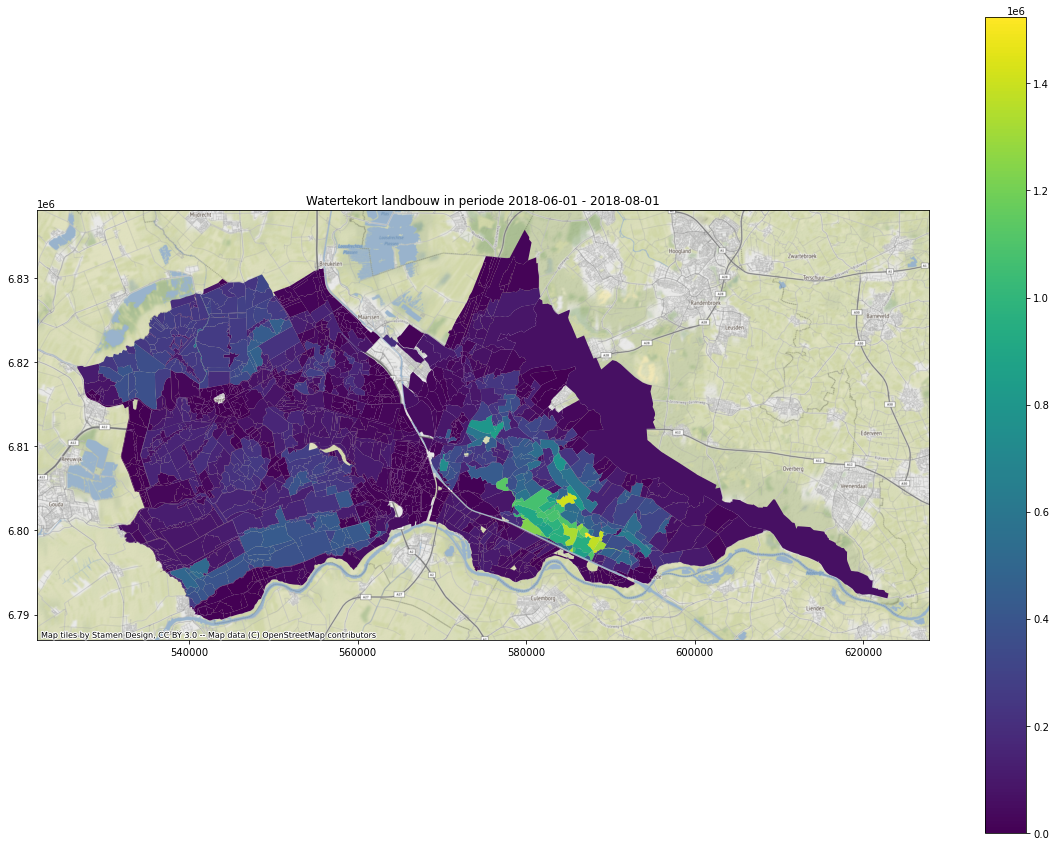

In [11]:
periode_start = '2018-06-01'
periode_end = '2018-08-01'
gebruiker = 'landbouw'
aspect = 'watertekort'

referentie.invoerdata['schaalgebied'][f'{aspect}{gebruiker}'] = np.nan

for index, row in referentie.invoerdata['schaalgebied'].iterrows():
    key = row['CODE']

    try:
        df = pd.read_csv(fr'{ref_dir}\mozart_schaalgebied_{key}_geschaald.csv',
                        parse_dates=True,
                        index_col=['TIMESTART'])

        df_tekort = df.loc[periode_start:periode_end, f'watertekort_{gebruiker}']

        totaal_tekort = df_tekort.sum()

        referentie.invoerdata['schaalgebied'].loc[index, f'{aspect}{gebruiker}'] = totaal_tekort.item()

    except FileNotFoundError:
        print(f"{row['CODE']} not found")

fig, ax = plt.subplots(figsize=(20, 15))
cbar = referentie.invoerdata['schaalgebied'].to_crs(epsg=3857).plot(ax=ax, column=f'{aspect}{gebruiker}', legend=True)
cx.add_basemap(ax)
ax.set_title(f'Watertekort {gebruiker} in periode {periode_start} - {periode_end}')


De onzekerheid in b.v. de geschaalde watervraag op basis van onnauwkeurigheden in top10nl kan gevisualiseerd worden als een bandbreedte. Hieronder is een voorbeeld te zien voor afwateringsgebied PG0714-42:

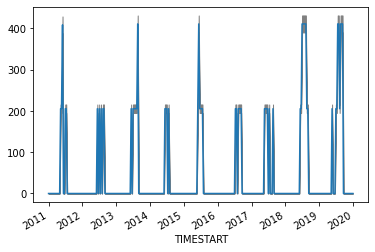

In [12]:
#%% visualisatie van onzekerheid oppervlakte top10nl (b.v. watervraag landbouw)
code_afwateringsgebied = 'PG0714-42'

df_ref = pd.read_csv(f'{ref_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])
df_min5 = pd.read_csv(f'{min5_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])
df_plus5 = pd.read_csv(f'{plus5_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])

fig, ax = plt.subplots()
df_ref['watervraag_landbouw'].plot(ax=ax, legend=False)
ax.fill_between(df_min5.index, df_min5['watervraag_landbouw'], df_plus5['watervraag_landbouw'], color='grey')


Tot slot kunnen de klimaatscenario's gebruikt worden om de toekomstige watervraag en behorend tekort in te schatten. Hiervoor wordt een factor berekend waarmee de referentie-modelresultaten geschaald worden. Ook kan er een onzekerheidsfactor op de klimaatfactor verdisconteerd worden om een onzekerheidsschatting van de toekomstschatting te maken. Vervolgens kunnen de toekomstige watervraag en bijbehorende onzekerheidsschatting gevisualiseerd worden in een figuur.

In [13]:
# definieer de scenarios
scenarios = ['REF2017', 'W2050']

# definieer de map waar de scenario-data staan
directory = os.path.join(data_path,'mozart')

# bepaal factor d.m.v. klimaatscenarios
referentie.bepaal_factor_klimaatscenarios(directory, scenarios)

# definieer onzekerheid klimaatfactor
onzekerheid_klimaat = 0.05 # 5%

df_ref_watervraag_toekomst = df_ref*referentie.klimaatfactor['watervraag']
df_min5_watervraag_toekomst = df_ref*(referentie.klimaatfactor['watervraag']-onzekerheid_klimaat)
df_plus5_watervraag_toekomst = df_ref*(referentie.klimaatfactor['watervraag']+onzekerheid_klimaat)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Factor watervraag is: 1.22 [-]
Factor wateraanbod is: 1.22 [-]


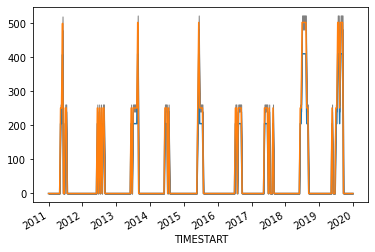

In [14]:
#%% visualisatie van onzekerheid klimaatscenarios
fig, ax = plt.subplots()

df_ref['watervraag_landbouw'].plot(ax=ax, legend=False)
df_ref_watervraag_toekomst['watervraag_landbouw'].plot(ax=ax, legend=False)
ax.fill_between(df_min5.index, df_min5_watervraag_toekomst['watervraag_landbouw'], df_plus5_watervraag_toekomst['watervraag_landbouw'],
                color='grey')

<a id='maatgevendeafaanvoer'/>

## 3.2 Maatgevende af- en aanvoer

Op basis van de laterale af- en aanvoer uit Hydromedah worden de maatgevende af- en aanvoer bepaald. De maatgevende afvoer is de dagelijks gemiddelde afvoer die 1 a 2 dagen per jaar wordt overschreden, de maatgevende aanvoer is de 10-daags gemiddelde aavvoer die ongeveer eens in de 10 jaar wordt overschreden.

Hydromedah geeft de laterale afvoer per afwateringseeneheid en dat is ook de ruimtelijke eenheid waarop de resultaten worden gepresenteerd. Aanvullend is inzicht gewenst in de bijdrage van kwel/wegzijging aan de maatgevende af- en aanvoer. We bepalen dus ook de laterale af- en aanvoer waarbij we per afwateringseenheid de kwel/wegzijging van de flux af trekken. Hierbij kan de kwel/wegzijging eerst zijn gemiddeld in de tijd (dat gaat snel), of niet (langzaam). De extra rekentijd wordt veroorzaakt door het bepalen van de gemiddelde flux per afwateringseenheid; in het eeste geval hoeft dat maar één keer.

Kies hier het de periode waarvoor de maatgevende afvoer bepaald dient te worden. De volledige code inclusief de bepaling van de bandbreedte werkt alleen voor de historische periode.

In [15]:
name = "Huidig250"
# name = "WH85250"
# name = "WL85250"
# name = "GH85250"

We bepalen eerst de lateralen zonder kwel/wegzijging.

In [16]:
mg = Maatgevend(name=name, export_path=export_path) 
mg.get_laterals(seepage_subtracted=False)
qnorm = mg.get_q_norm(dataset = mg.laterals)

  0%|          | 0/1831 [00:00<?, ?it/s]

Bereken nu de lateralen zonder kwel/wegzijging. Deze worden ook in CSV-formaat in de export_folder geplaatst. Kies met 'mean_seepage' voor al dan niet gemiddelde kwel/wegzijging.

In [17]:
mg.subtract_seepage(mean_seepage = True , model_path = hydromedah_path, name=name)
mg.get_laterals(seepage_subtracted=True, mean_seepage=True)
qnorm_nosp = mg.get_q_norm(dataset = mg.laterals_nosp)

  0%|          | 0/4230 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

We exporteren de resultaten met en zonder kwel naar shape-bestanden. Deze bevatten zowel maatgevende aan- als afvoer in zowel m3/s als l/s/ha.

In [18]:
qnorm.head()

,CODE,geometry,CODENR,MQAF_M3S,MQAF_LSHA,MQAAN_M3S,MQAAN_LSHA
0,PG0003-1,"POLYGON ((138767.331 444719.836, 138724.919 44...",1,0.026891,0.850575,0.001503,0.047536
1,PG0004-1,"POLYGON ((146292.733 443230.648, 146289.877 44...",2,0.000000,0.000000,0.087601,1.070805
2,PG0006-1,"POLYGON ((145893.054 443602.715, 145886.623 44...",3,0.171858,6.887406,0.000166,0.006659
3,PG0007-1,"POLYGON ((139331.829 443471.812, 139330.109 44...",4,0.015295,0.740333,0.000040,0.001936
4,PG0008-1,"POLYGON ((139980.443 442641.467, 139973.696 44...",5,0.059582,1.242248,0.001308,0.027267


<AxesSubplot:>

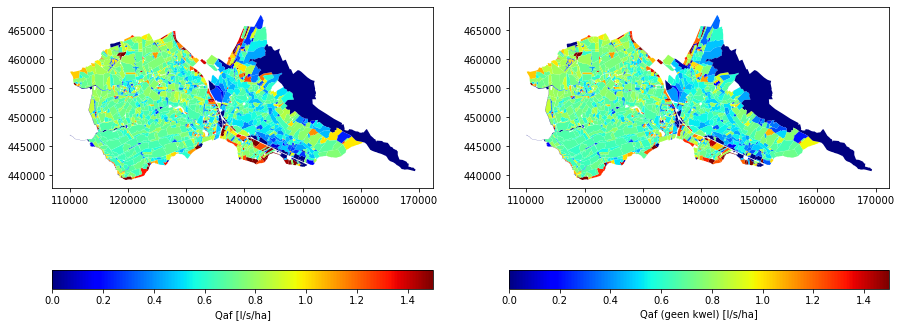

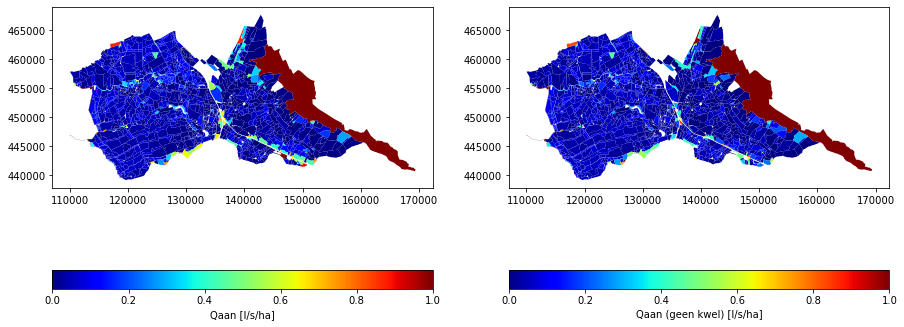

In [19]:
matplotlib.rcParams['figure.figsize'] = [15,10]
fig, ax = plt.subplots(1,2)
qnorm.plot('MQAF_LSHA',ax=ax[0],cmap='jet', vmin=0,vmax=1.5, legend=True, legend_kwds={'label': "Qaf [l/s/ha]",'orientation': "horizontal"})

qnorm_nosp.plot('MQAF_LSHA',ax=ax[1],cmap='jet', vmin=0,vmax=1.5,legend=True , legend_kwds={'label': "Qaf (geen kwel) [l/s/ha]",'orientation': "horizontal"})
fig, ax = plt.subplots(1,2)
qnorm.plot('MQAAN_LSHA',ax=ax[0],cmap='jet',vmin=0,vmax=1, legend=True , legend_kwds={'label': "Qaan [l/s/ha]",'orientation': "horizontal"})
qnorm_nosp.plot('MQAAN_LSHA',ax=ax[1],cmap='jet',vmin=0,vmax=1, legend=True , legend_kwds={'label': "Qaan (geen kwel) [l/s/ha]",'orientation': "horizontal"})


Ook is er een functie ingebouwd om resultaten voor een bepaalde locatie nader te bekijken. Deze heeft als invoer het volgnummer van de afwateringseenheid in de shape (dit is wat Hydromedah als codering gebruikt). Hierbij kan alleen de ruwe data (seepage_subtracted=False), of de data zonder kwel/wegzijging (seepage_subtraced=True) geplot worden. De plaatjes worden als PNG weggeschreven naar de export map.

Plotting PG0049-16


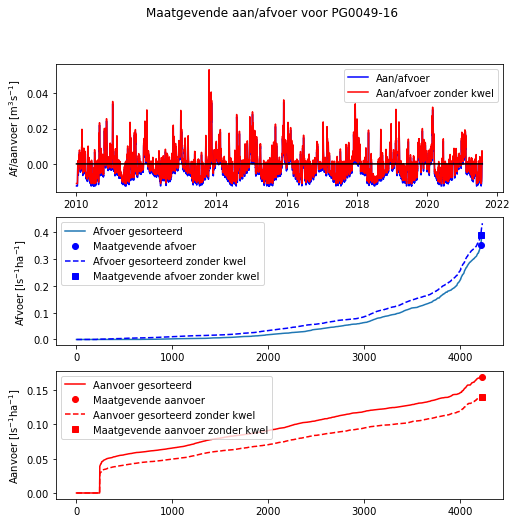

In [20]:
%matplotlib inline
mg.plot_location(113, seepage_subtracted=True)

Op onderstaande manier kan een figuur worden verkregen voor alle locaties. Er zijn enkele kleine of langgerekte gebieden waaraan geen Hydromedah cel kan worden gealloceerd en waarvoor geen data beschikbaar is: deze worden overgeslagen.

Plotting PG0003-1
Figure failed.
Plotting PG0179-2
Figure failed.
Plotting PG0355-2
Plotting PG0549-1
Plotting PG0714-27
Figure failed.
Plotting PG1527-12
Figure failed.


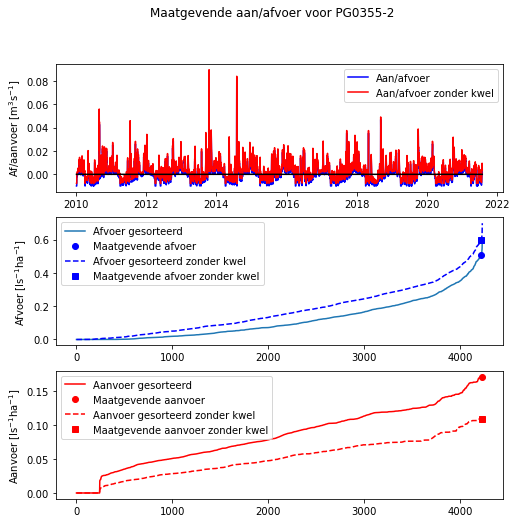

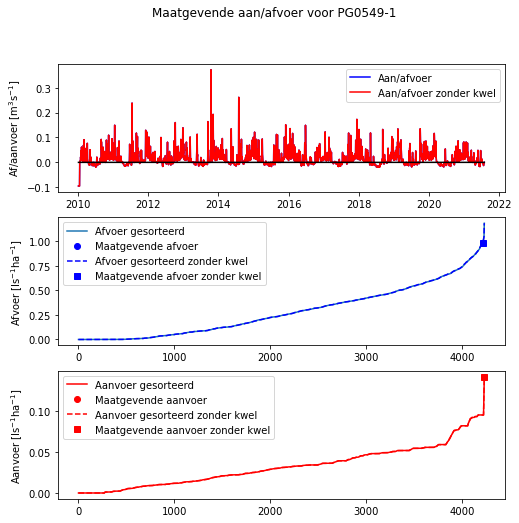

In [21]:
plotting = range(1,1800,300)
for i in plotting:
     try:
         mg.plot_location(i, seepage_subtracted=True)
     except:
         print('Figure failed.')

De bandbreedte voor de Monte Carlo-analyse leiden we af uit tijdreeksen van af- en aanvoeren uit het WIS. Gevalideerde metingen zijn geaggregeerd naar afvoergebieden. De data van niet elk afvoergebied kan rechtstreeks gebruikt worden, aangezien sommige afvoergebieden op elkaar afwateren. 

Eerst bewerken we de de geaggregeerde metingen en maken er dataframe van af- en aanvoer van.

In [22]:
# read and preprocess the validation data
validation_series = os.path.join(data_path,'surfacewater','debieten_afvoergebieden.csv')
data = pd.read_csv(validation_series)
data[data=='-999'] = np.nan
data.drop([col for col in data.columns if 'quality' in col], axis=1, inplace=True)
afvoer = data.iloc[:,[i for i in range(len(data.columns)) if data.iloc[0,i] == 'H.B.u.d']]
aanvoer = data.iloc[:, [i for i in range(len(data.columns)) if data.iloc[0,i] == 'H.B.i.d']]
afvoer.drop([0], axis=0, inplace=True)
aanvoer.drop([0], axis=0, inplace=True)
afvoer.index = [pd.Timestamp(data.iloc[i,0]) for i in range(len(data.iloc[1:,0]))]
afvoer.columns = [afv.rstrip('.1') if '.1' in afv else afv for afv in afvoer.columns]
aanvoer.index  = [pd.Timestamp(data.iloc[i,0]) for i in range(len(data.iloc[1:,0]))]

<a id='gxg'/>

We kiezen afvoergebied Zegveld, uiteraard is hier een ander gebied voor te nemen dat geen afvoer ontvangt van bovenstroomse gebieden.

In [23]:
if name=='Huidig250':
    afgid = 'AFVG13' # Zegveld
    netto = mg.get_validation(afgid=afgid, afvoer=afvoer, aanvoer=aanvoer)

we plotten de twee reeksen en het onderlinge verschil, en bepalen de bandbreedte als die afwijking waar één standaardafwijking (67%) van de datapunten in valt.

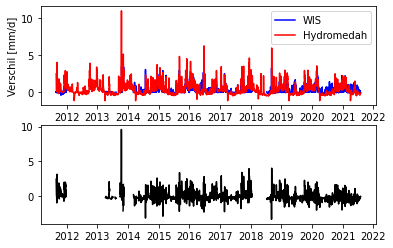

In [24]:
if name=='Huidig250':
    fig, axs = plt.subplots(2)
    axs[0].plot(netto.WIS,color='blue', label='WIS')
    axs[0].plot(netto.HYDROMEDAH,color='red', label='Hydromedah')
    axs[0].legend()
    axs[0].set_ylabel('Verschil [mm/d]')
    axs[1].plot(netto.HYDROMEDAH-netto.WIS,color='black', label='Verschil')
    mg_bandwidth = [np.percentile(netto.ERROR, 17), np.percentile(netto.ERROR, 83)]

Deze bandbreedte combineren we met een bootstrap. We voegen de uitersten toe aan een shapefile en schrijven die weg. Dit is het eindresultaat.

In [25]:
if name=='Huidig250':
    mg_samples = sample_nauwkeurigheid(mg.laterals, mg_bandwidth, n=2)
    (mins, maxs)  = MonteCarlo('normative', mg_samples, bootstrap_n=2, n=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

In [26]:
if name=='Huidig250':
    qnorm['QAF_LSHA_MIN'] = mins[0]
    qnorm['QAAN_LSHA_MIN'] = mins[1]
    qnorm['QAF_LSHA_MAX'] = maxs[0]
    qnorm['QAAN_LSHA_MAX'] = maxs[1]

In [27]:
mg.export_shp(qnorm, 'Qm_'+name+'.shp')
mg.export_shp(qnorm_nosp, 'Qm_'+name+'_geen_kwel.shp')

# 3.3 GxG's en grondwatertrap

Op basis van de Modflow uitvoer bepalen stellen we de volgende kaarten samen:
 - GHG (gemiddelde van de drie hoogste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GLG (gemiddelde van de drie laagste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GVG (gemiddelde grondwaterstand over 14 maart, 28  maart en 14 april, gemiddeld over tenminste 8 jaar);
 - GT (grondwatertrap, gebaseerd op de drie GxG-kaarten).
 
 We stellen eerst deze producten samen op basis van de complete meetreeks, en voegen hierna de nauwkeurigheid daaraan toe.

We maken eerst een 'groundwater' - object aan en geven de paden en naam van de Hydromedah-berekening mee. Resultaten worden naar 'export_path' geschreven.

In [28]:
# initialiseer het object. De hierboven gedefinieerde locaties voor modeluitvoer e.d. worden meegegeven.
gw = Groundwater(model_path=hydromedah_path, export_path=export_path, name='Huidig250')

Haal de stijdghoogtes op uit Hydromedah.

In [29]:
gw.get_heads_raster()

Bereken de GxG's. Deze worden omgerekend naar diepte onder maaiveld via een maaiveldraster. Standaard wordt het Hydromedah raster (25m) geaggregeerd naar de modelresolutie en gebruikt, maar een alternatief is op te geven.

In [40]:
means = gw.get_gxg_raster(mv_raster=None)

Plot de resultaten:

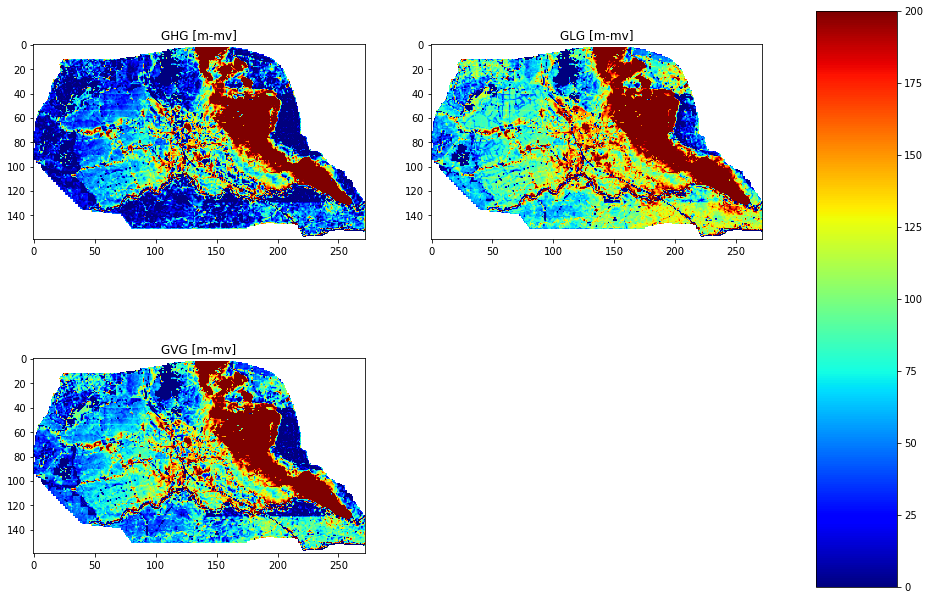

In [31]:
matplotlib.rcParams['figure.figsize'] = [15,10]
ax1 = plt.subplot(221)
plt.imshow(means['ghg'], cmap='jet', vmin=0,vmax=200)
ax1.set_title('GHG [m-mv]')
ax2 = plt.subplot(222)
plt.imshow(means['glg'], cmap='jet', vmin=0,vmax=200)
ax2.set_title('GLG [m-mv]')
ax3 = plt.subplot(223)
plt.imshow(means['gvg'], cmap='jet', vmin=0,vmax=200)
ax3.set_title('GVG [m-mv]')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

Op basis van de GxG's wordt de grondwatertrappenkaart berekend. Onderstaande indeling van grondwatertrappen is aangehouden (uit: Knotters e.a. (2018), Landsdekkende, actuele informatie over grondwatertrappen digitaal
beschikbaar, H20.)

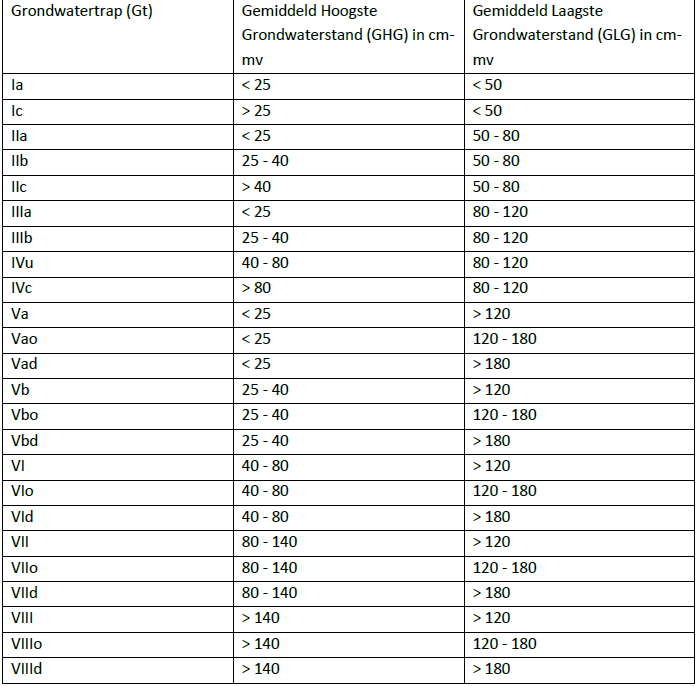

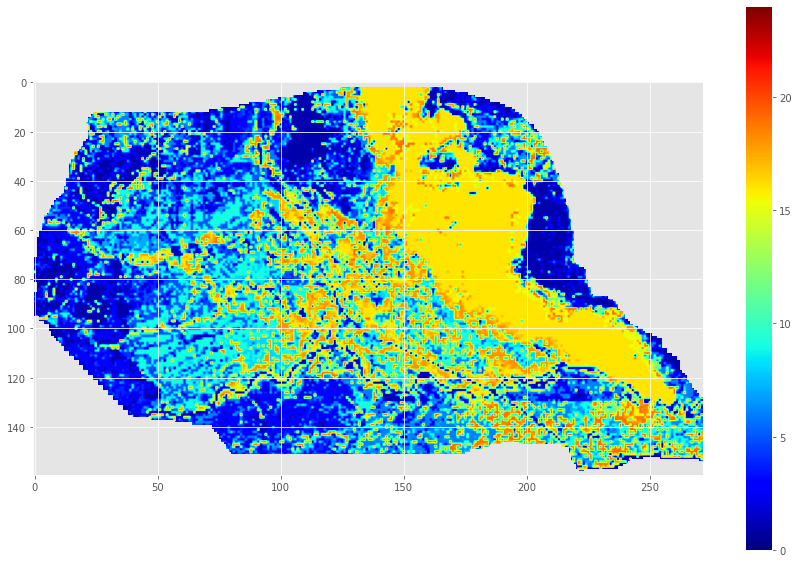

In [44]:
means['gt'] = gw.get_gt_raster(gxg=means)

plt.imshow(means['gt'], cmap='jet', vmin=0, vmax=24)
plt.colorbar()
plt.show()

Vervolgens wordt, op basis van code uit de validatie van het LHM, een validatie van Hydromedah-grondwaterstanden uitgevoerd. Hiervoor is een gecombineerde dataset samengesteld van peilbuizen in het bovenste (freatische) watervoerende pakket, voor de periode 01/01/2010 - 31/7/2021 - dezelfde periode als bovenstaande Hydromedah run. 

'get_validation_data' roept de code aan die is overgenomen uit het project 'validatie_LHM' om statistieken te berekenen en een vergelijkingstabel met Hydromedah te maken.

In [33]:
catalogue_file = 'alle_aanwezig.csv'
timeseries_file = 'alle_reeksen.csv'
head_path = os.path.join(hydromedah_path, 'work', 'Huidig250', 'output', 'head')     
gw.get_validation_data(validation_path=os.path.join(data_path,'grondwater'), catalogue=catalogue_file, timeseries=timeseries_file, head_path=head_path)

# selected = 211
# recession = 13
# deselected = 99
   Total added: 224
Adding KNMI data
reading head data : started
reading head data : done
Time series analysis : started
Time series modelling


  0%|          | 0/127 [00:00<?, ?it/s]

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 590 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D
INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    35                     EVP           69.33
nobs    3238                   R2             0.69
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -25260.83
tmax    2021-06-24 00:00:00    BIC       -25224.34
freq    D                      Obj            0.66
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.027908  ±6.63%   0.190531  True
rainevap_n    0.961779  ±2.00%   1.000000  True
rainevap_a    8.815498  ±9.22%  10.000000  True
rainevap_f   -2.000000  ±7.11%  -1.000000  True
constant_d   -2.134829  ±0.33%  -2.143372  True
noise_alpha  11.569936  ±8.87%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 313 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


1 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    26                     EVP           68.90
nobs    3073                   R2             0.68
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -24119.91
tmax    2020-04-08 00:00:00    BIC       -24083.73
freq    D                      Obj            0.60
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.028055  ±6.62%   0.190531  True
rainevap_n    0.972530  ±1.95%   1.000000  True
rainevap_a    8.339858  ±9.15%  10.000000  True
rainevap_f   -2.000000  ±7.12%  -1.000000  True
constant_d   -2.134676  ±0.35%  -2.142768  True
noise_alpha  13.127273  ±9.65%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 313 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


2 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    26                     EVP           68.90
nobs    3073                   R2             0.68
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -24119.91
tmax    2020-04-08 00:00:00    BIC       -24083.73
freq    D                      Obj            0.60
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.028055  ±6.62%   0.190531  True
rainevap_n    0.972530  ±1.95%   1.000000  True
rainevap_a    8.339858  ±9.15%  10.000000  True
rainevap_f   -2.000000  ±7.12%  -1.000000  True
constant_d   -2.134676  ±0.35%  -2.142768  True
noise_alpha  13.127273  ±9.65%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 723 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


3 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    40                     EVP           66.05
nobs    3105                   R2             0.63
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -25222.89
tmax    2021-06-24 00:00:00    BIC       -25186.64
freq    D                      Obj            0.46
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.027829   ±6.78%   0.190531  True
rainevap_n    1.203205   ±1.82%   1.000000  True
rainevap_a    6.867667   ±7.80%  10.000000  True
rainevap_f   -2.000000   ±8.76%  -1.000000  True
constant_d   -2.151235   ±0.48%  -2.146691  True
noise_alpha  25.141923  ±12.80%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 474 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


4 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    40                     EVP           65.95
nobs    2912                   R2             0.63
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -23822.81
tmax    2020-04-08 00:00:00    BIC       -23786.96
freq    D                      Obj            0.41
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.026902   ±6.99%   0.190531  True
rainevap_n    1.200863   ±1.87%   1.000000  True
rainevap_a    6.873013   ±8.07%  10.000000  True
rainevap_f   -2.000000   ±9.16%  -1.000000  True
constant_d   -2.150442   ±0.49%  -2.144141  True
noise_alpha  25.914780  ±13.46%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 255 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


5 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    21                     EVP           50.29
nobs    3578                   R2             0.50
noise   True                   RMSE           0.07
tmin    2011-01-01 00:00:00    AIC       -33446.37
tmax    2021-06-29 00:00:00    BIC       -33409.28
freq    D                      Obj            0.16
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.027174   ±2.95%   0.190531  True
rainevap_n     1.821547   ±1.21%   1.000000  True
rainevap_a     3.784344   ±3.07%  10.000000  True
rainevap_f    -0.434475  ±20.69%  -1.000000  True
constant_d    -2.656869   ±0.72%  -2.609566  True
noise_alpha  125.490332  ±26.97%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    24                     EVP                55.12
nobs    3578                   R2                 0.55
noise   True                   RMSE                 0.07
tmin    2011-01-01 00:00:00    AIC            -33447.82
tmax    2021-06-29 00:00:00    BIC            -33404.54
freq    D                      Obj                 0.16
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.027200   ±2.96%       0.190531   True
rainevap_n                1.820495   ±1.20%       1.000000   True
rainevap_a                3.791282   ±3.07%      10.000000   True
rainevap_f               -0.444623  ±20.21%      -1.000000   True
linear_trend_a           -0.000027  ±51.36%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 350 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


6 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    34                     EVP           72.40
nobs    3480                   R2             0.72
noise   True                   RMSE           0.09
tmin    2011-01-01 00:00:00    AIC       -30204.67
tmax    2021-06-26 00:00:00    BIC       -30167.74
freq    D                      Obj            0.29
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.047503   ±6.02%   0.190531  True
rainevap_n    1.480224   ±1.47%   1.000000  True
rainevap_a    9.891823   ±5.69%  10.000000  True
rainevap_f   -1.698847   ±8.95%  -1.000000  True
constant_d   -2.524651   ±0.85%  -2.550530  True
noise_alpha  86.409669  ±22.07%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 71 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


7 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    29                     EVP           73.61
nobs    3337                   R2             0.74
noise   True                   RMSE           0.08
tmin    2011-01-01 00:00:00    AIC       -28942.86
tmax    2020-04-30 00:00:00    BIC       -28906.18
freq    D                      Obj            0.28
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.047425   ±6.17%   0.190531  True
rainevap_n    1.486384   ±1.52%   1.000000  True
rainevap_a    9.874449   ±5.82%  10.000000  True
rainevap_f   -1.726809   ±9.11%  -1.000000  True
constant_d   -2.530873   ±0.83%  -2.556603  True
noise_alpha  79.096242  ±21.61%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 10 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


8 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           84.81
nobs    1498                   R2             0.85
noise   True                   RMSE           0.06
tmin    2012-11-06 00:00:00    AIC       -12832.72
tmax    2016-12-22 00:00:00    BIC       -12800.85
freq    D                      Obj            0.14
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.063727   ±8.71%   0.190531  True
rainevap_n    1.293329   ±1.78%   1.000000  True
rainevap_a   13.339831   ±8.72%  10.000000  True
rainevap_f   -1.451049  ±11.58%  -1.000000  True
constant_d   -2.614233   ±0.86%  -2.605069  True
noise_alpha  39.820293  ±23.54%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 1961 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


9 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    35                     EVP           42.34
nobs    1872                   R2             0.42
noise   True                   RMSE           0.16
tmin    2011-01-01 00:00:00    AIC       -12821.36
tmax    2021-06-29 00:00:00    BIC       -12788.15
freq    D                      Obj            0.99
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.028862   ±8.63%   0.190531  True
rainevap_n    1.459148   ±3.34%   1.000000  True
rainevap_a    3.296702  ±10.23%  10.000000  True
rainevap_f   -1.439998  ±19.14%  -1.000000  True
constant_d   -2.625157   ±1.36%  -2.636311  True
noise_alpha  46.223932  ±22.16%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    40                     EVP                49.13
nobs    1872                   R2                 0.49
noise   True                   RMSE                 0.15
tmin    2011-01-01 00:00:00    AIC            -12822.00
tmax    2021-06-29 00:00:00    BIC            -12783.25
freq    D                      Obj                 0.98
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.029983   ±8.77%       0.190531   True
rainevap_n                1.436942   ±3.29%       1.000000   True
rainevap_a                3.505715  ±10.35%      10.000000   True
rainevap_f               -1.519690  ±18.14%      -1.000000   True
linear_trend_a           -0.000038  ±57.61%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 1716 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


10 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    36                     EVP           41.26
nobs    1692                   R2             0.41
noise   True                   RMSE           0.16
tmin    2011-01-01 00:00:00    AIC       -11902.81
tmax    2020-04-30 00:00:00    BIC       -11870.21
freq    D                      Obj            0.74
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.027994   ±7.93%   0.190531  True
rainevap_n    1.500577   ±3.19%   1.000000  True
rainevap_a    3.090338   ±9.40%  10.000000  True
rainevap_f   -1.468379  ±18.20%  -1.000000  True
constant_d   -2.626863   ±1.61%  -2.641015  True
noise_alpha  59.240429  ±26.27%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    42                     EVP                50.07
nobs    1692                   R2                 0.50
noise   True                   RMSE                 0.15
tmin    2011-01-01 00:00:00    AIC            -11904.26
tmax    2020-04-30 00:00:00    BIC            -11866.23
freq    D                      Obj                 0.74
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.028658   ±8.01%       0.190531   True
rainevap_n                1.485132   ±3.15%       1.000000   True
rainevap_a                3.212797   ±9.44%      10.000000   True
rainevap_f               -1.537297  ±17.42%      -1.000000   True
linear_trend_a           -0.000053  ±49.83%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 4 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


11 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    35                     EVP           79.72
nobs    1655                   R2             0.80
noise   True                   RMSE           0.06
tmin    2011-01-01 00:00:00    AIC       -14772.31
tmax    2015-07-17 00:00:00    BIC       -14739.84
freq    D                      Obj            0.11
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.044012   ±8.40%   0.190531  True
rainevap_n    1.345424   ±1.81%   1.000000  True
rainevap_a   10.551786   ±8.22%  10.000000  True
rainevap_f   -1.980266  ±10.26%  -1.000000  True
constant_d   -2.617779   ±0.91%  -2.653353  True
noise_alpha  72.246390  ±32.99%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    35                     EVP                82.85
nobs    1655                   R2                 0.83
noise   True                   RMSE                 0.06
tmin    2011-01-01 00:00:00    AIC            -14776.46
tmax    2015-07-17 00:00:00    BIC            -14738.58
freq    D                      Obj                 0.11
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.044037   ±8.27%       0.190531   True
rainevap_n                1.345662   ±1.80%       1.000000   True
rainevap_a               10.550997   ±8.04%      10.000000   True
rainevap_f               -1.968755  ±10.03%      -1.000000   True
linear_trend_a           -0.000080  ±36.76%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 348 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


12 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    40                     EVP           80.07
nobs    2810                   R2             0.80
noise   True                   RMSE           0.10
tmin    2012-11-06 00:00:00    AIC       -22068.88
tmax    2021-06-29 00:00:00    BIC       -22033.23
freq    D                      Obj            0.54
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.063320   ±6.32%   0.190531  True
rainevap_n    1.378488   ±1.53%   1.000000  True
rainevap_a    9.427145   ±6.31%  10.000000  True
rainevap_f   -1.585301   ±9.48%  -1.000000  True
constant_d   -2.608228   ±0.86%  -2.616990  True
noise_alpha  44.213208  ±17.89%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 338 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


13 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    22                     EVP           59.52
nobs    3495                   R2             0.59
noise   True                   RMSE           0.19
tmin    2011-01-01 00:00:00    AIC       -24864.36
tmax    2021-06-29 00:00:00    BIC       -24827.41
freq    D                      Obj            1.42
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.070297   ±8.02%   0.190531  True
rainevap_n    1.352702   ±1.82%   1.000000  True
rainevap_a   10.182496   ±7.97%  10.000000  True
rainevap_f   -2.000000  ±10.37%  -1.000000  True
constant_d   -2.342158   ±1.93%  -2.393687  True
noise_alpha  86.245348  ±22.02%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    27                     EVP                63.80
nobs    3495                   R2                 0.64
noise   True                   RMSE                 0.18
tmin    2011-01-01 00:00:00    AIC            -24863.30
tmax    2021-06-29 00:00:00    BIC            -24820.19
freq    D                      Obj                 1.42
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.072437   ±8.05%       0.190531   True
rainevap_n                1.346600   ±1.80%       1.000000   True
rainevap_a               10.547983   ±7.98%      10.000000   True
rainevap_f               -1.999999  ±10.26%      -1.000000   True
linear_trend_a            0.000035  ±89.82%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 545 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


14 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)     Fit Statistics
nfev    30                     EVP           63.82
nobs    3283                   R2             0.64
noise   True                   RMSE           0.02
tmin    2011-01-01 00:00:00    AIC       -28342.15
tmax    2021-06-24 00:00:00    BIC       -28305.57
freq    D                      Obj            0.29
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal  stderr    initial  vary
rainevap_A   0.008951  ±5.15%   0.190531  True
rainevap_n   1.162170  ±2.90%   1.000000  True
rainevap_a   2.891675  ±8.21%  10.000000  True
rainevap_f  -1.989374  ±7.10%  -1.000000  True
constant_d  -2.188186  ±0.11%  -2.195000  True
noise_alpha  6.102753  ±6.67%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 278 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


15 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)     Fit Statistics
nfev    53                     EVP           63.24
nobs    3108                   R2             0.63
noise   True                   RMSE           0.03
tmin    2011-01-01 00:00:00    AIC       -26864.55
tmax    2020-04-08 00:00:00    BIC       -26828.30
freq    D                      Obj            0.27
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal  stderr    initial  vary
rainevap_A   0.008891  ±5.13%   0.190531  True
rainevap_n   1.184546  ±2.92%   1.000000  True
rainevap_a   2.710076  ±8.15%  10.000000  True
rainevap_f  -1.998033  ±7.27%  -1.000000  True
constant_d  -2.188037  ±0.12%  -2.194715  True
noise_alpha  6.600275  ±7.12%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 278 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


16 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)     Fit Statistics
nfev    53                     EVP           63.24
nobs    3108                   R2             0.63
noise   True                   RMSE           0.03
tmin    2011-01-01 00:00:00    AIC       -26864.55
tmax    2020-04-08 00:00:00    BIC       -26828.30
freq    D                      Obj            0.27
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal  stderr    initial  vary
rainevap_A   0.008891  ±5.13%   0.190531  True
rainevap_n   1.184546  ±2.92%   1.000000  True
rainevap_a   2.710076  ±8.15%  10.000000  True
rainevap_f  -1.998033  ±7.27%  -1.000000  True
constant_d  -2.188037  ±0.12%  -2.194715  True
noise_alpha  6.600275  ±7.12%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 278 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


17 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)     Fit Statistics
nfev    53                     EVP           63.24
nobs    3108                   R2             0.63
noise   True                   RMSE           0.03
tmin    2011-01-01 00:00:00    AIC       -26864.55
tmax    2020-04-08 00:00:00    BIC       -26828.30
freq    D                      Obj            0.27
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal  stderr    initial  vary
rainevap_A   0.008891  ±5.13%   0.190531  True
rainevap_n   1.184546  ±2.92%   1.000000  True
rainevap_a   2.710076  ±8.15%  10.000000  True
rainevap_f  -1.998033  ±7.27%  -1.000000  True
constant_d  -2.188037  ±0.12%  -2.194715  True
noise_alpha  6.600275  ±7.12%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 278 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


18 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)     Fit Statistics
nfev    53                     EVP           63.24
nobs    3108                   R2             0.63
noise   True                   RMSE           0.03
tmin    2011-01-01 00:00:00    AIC       -26864.55
tmax    2020-04-08 00:00:00    BIC       -26828.30
freq    D                      Obj            0.27
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal  stderr    initial  vary
rainevap_A   0.008891  ±5.13%   0.190531  True
rainevap_n   1.184546  ±2.92%   1.000000  True
rainevap_a   2.710076  ±8.15%  10.000000  True
rainevap_f  -1.998033  ±7.27%  -1.000000  True
constant_d  -2.188037  ±0.12%  -2.194715  True
noise_alpha  6.600275  ±7.12%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 309 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


19 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    61                     EVP           24.43
nobs    2502                   R2             0.24
noise   True                   RMSE           0.18
tmin    2013-09-26 00:00:00    AIC       -17878.05
tmax    2021-06-06 00:00:00    BIC       -17843.10
freq    D                      Obj            0.98
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.023026   ±5.79%   0.190531  True
rainevap_n    1.842002   ±2.97%   1.000000  True
rainevap_a    2.135908   ±6.71%  10.000000  True
rainevap_f   -0.870629  ±25.69%  -1.000000  True
constant_d   -3.035677   ±1.59%  -2.992937  True
noise_alpha  91.054440  ±26.15%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 59 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


20 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    61                     EVP           20.80
nobs    2350                   R2             0.20
noise   True                   RMSE           0.19
tmin    2013-09-26 00:00:00    AIC       -16836.73
tmax    2020-04-30 00:00:00    BIC       -16802.16
freq    D                      Obj            0.90
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.021390   ±5.58%   0.190531  True
rainevap_n     1.942396   ±3.10%   1.000000  True
rainevap_a     1.865854   ±6.54%  10.000000  True
rainevap_f    -0.763913  ±29.43%  -1.000000  True
constant_d    -3.046517   ±1.89%  -2.997149  True
noise_alpha  104.802166  ±29.47%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 256 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


21 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    26                     EVP           82.96
nobs    2556                   R2             0.83
noise   True                   RMSE           0.07
tmin    2013-09-25 00:00:00    AIC       -22551.14
tmax    2021-06-06 00:00:00    BIC       -22516.06
freq    D                      Obj            0.19
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.044714   ±5.97%   0.190531  True
rainevap_n    1.456474   ±1.50%   1.000000  True
rainevap_a    9.375499   ±5.73%  10.000000  True
rainevap_f   -2.000000   ±8.11%  -1.000000  True
constant_d   -2.963790   ±0.59%  -2.995839  True
noise_alpha  58.348356  ±21.34%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 267 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


22 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           86.17
nobs    1391                   R2             0.86
noise   True                   RMSE           0.04
tmin    2016-12-10 00:00:00    AIC       -12221.94
tmax    2021-06-24 00:00:00    BIC       -12190.51
freq    D                      Obj            0.11
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.039026  ±14.62%   0.190531  True
rainevap_n    1.109311   ±2.69%   1.000000  True
rainevap_a   20.721015  ±15.01%  10.000000  True
rainevap_f   -1.760000  ±15.15%  -1.000000  True
constant_d   -2.235698   ±0.76%  -2.250884  True
noise_alpha  22.881417  ±19.47%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 247 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


23 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    32                     EVP           70.60
nobs    1558                   R2             0.71
noise   True                   RMSE           0.07
tmin    2016-07-21 00:00:00    AIC       -15060.96
tmax    2021-06-29 00:00:00    BIC       -15028.85
freq    D                      Obj            0.05
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.030705   ±6.13%   0.190987  True
rainevap_n     1.601880   ±1.84%   1.000000  True
rainevap_a     7.172535   ±5.96%  10.000000  True
rainevap_f    -1.488882  ±11.67%  -1.000000  True
constant_d    -2.343095   ±1.29%  -2.348970  True
noise_alpha  163.806842  ±43.61%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 263 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


24 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP           21.77
nobs    1542                   R2             0.22
noise   True                   RMSE           0.16
tmin    2016-07-21 00:00:00    AIC       -10615.16
tmax    2021-06-29 00:00:00    BIC       -10583.11
freq    D                      Obj            0.78
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.021994  ±19.48%   0.190987  True
rainevap_n    1.561326   ±6.64%   1.000000  True
rainevap_a    4.593030  ±20.69%  10.000000  True
rainevap_f   -1.254587  ±45.47%  -1.000000  True
constant_d   -2.302891   ±1.94%  -2.303280  True
noise_alpha  50.568287  ±26.56%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 446 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


25 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    34                     EVP           18.76
nobs    1359                   R2             0.15
noise   True                   RMSE           0.20
tmin    2016-07-21 00:00:00    AIC        -7560.09
tmax    2021-06-29 00:00:00    BIC        -7528.81
freq    D                      Obj            2.58
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.025493   ±9.05%   0.190987  True
rainevap_n    2.357337   ±6.76%   1.000000  True
rainevap_a    1.147448  ±11.47%  10.000000  True
rainevap_f   -0.570401  ±62.05%  -1.000000  True
constant_d   -2.149153   ±1.96%  -2.161814  True
noise_alpha  25.197359  ±18.85%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 82 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


26 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    36                     EVP           52.16
nobs    906                    R2             0.52
noise   True                   RMSE           0.15
tmin    2016-07-21 00:00:00    AIC        -5249.77
tmax    2019-04-04 00:00:00    BIC        -5220.91
freq    D                      Obj            1.36
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.032733  ±13.50%   0.190987  True
rainevap_n    1.229263   ±5.98%   1.000000  True
rainevap_a    3.337713  ±19.01%  10.000000  True
rainevap_f   -2.000000  ±20.77%  -1.000000  True
constant_d   -2.148224   ±1.53%  -2.192426  True
noise_alpha  13.780605  ±18.05%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 258 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


27 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    24                     EVP           66.17
nobs    1547                   R2             0.66
noise   True                   RMSE           0.11
tmin    2016-07-21 00:00:00    AIC        -9326.07
tmax    2021-06-29 00:00:00    BIC        -9294.01
freq    D                      Obj            1.85
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal   stderr    initial  vary
rainevap_A   0.050482  ±13.47%   0.190987  True
rainevap_n   1.100188   ±4.22%   1.000000  True
rainevap_a   8.789862  ±17.03%  10.000000  True
rainevap_f  -1.844575  ±16.00%  -1.000000  True
constant_d  -2.481235   ±1.00%  -2.514831  True
noise_alpha  9.556845  ±11.71%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 264 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


28 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    28                     EVP           52.27
nobs    1541                   R2             0.52
noise   True                   RMSE           0.11
tmin    2016-07-21 00:00:00    AIC       -11690.31
tmax    2021-06-29 00:00:00    BIC       -11658.27
freq    D                      Obj            0.39
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.034912  ±12.70%   0.190987  True
rainevap_n    1.328047   ±3.30%   1.000000  True
rainevap_a    7.374148  ±13.63%  10.000000  True
rainevap_f   -1.623212  ±19.59%  -1.000000  True
constant_d   -2.183324   ±1.50%  -2.190310  True
noise_alpha  49.761595  ±24.88%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 350 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


29 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    22                     EVP           84.24
nobs    1185                   R2             0.84
noise   True                   RMSE           0.09
tmin    2017-04-12 00:00:00    AIC        -7190.41
tmax    2021-06-24 00:00:00    BIC        -7159.94
freq    D                      Obj            1.36
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.108564  ±15.55%   0.190987  True
rainevap_n    0.894066   ±3.92%   1.000000  True
rainevap_a   49.988109  ±13.67%  10.000000  True
rainevap_f   -1.739511  ±15.87%  -1.000000  True
constant_d   -2.197951   ±2.07%  -2.248683  True
noise_alpha   6.822728  ±11.70%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 357 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


30 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    20                     EVP           82.63
nobs    1178                   R2             0.83
noise   True                   RMSE           0.09
tmin    2017-04-12 00:00:00    AIC        -7899.33
tmax    2021-06-24 00:00:00    BIC        -7868.90
freq    D                      Obj            0.71
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.070014  ±14.16%   0.190987  True
rainevap_n    1.241673   ±3.60%   1.000000  True
rainevap_a   13.100614  ±14.39%  10.000000  True
rainevap_f   -1.972141  ±16.33%  -1.000000  True
constant_d   -2.270628   ±1.55%  -2.338647  True
noise_alpha  13.627576  ±15.85%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 272 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


31 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    23                     EVP           82.73
nobs    1263                   R2             0.83
noise   True                   RMSE           0.13
tmin    2017-04-12 00:00:00    AIC        -7581.76
tmax    2021-06-24 00:00:00    BIC        -7550.91
freq    D                      Obj            1.55
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.098327  ±15.52%   0.190987  True
rainevap_n    1.247903   ±3.87%   1.000000  True
rainevap_a   14.596767  ±15.42%  10.000000  True
rainevap_f   -2.000000  ±17.62%  -1.000000  True
constant_d   -2.351977   ±2.19%  -2.433610  True
noise_alpha  13.180219  ±15.24%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 270 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


32 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           84.69
nobs    1265                   R2             0.85
noise   True                   RMSE           0.11
tmin    2017-04-12 00:00:00    AIC        -8207.02
tmax    2021-06-24 00:00:00    BIC        -8176.16
freq    D                      Obj            0.95
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.094030  ±13.21%   0.190987  True
rainevap_n    1.258389   ±3.21%   1.000000  True
rainevap_a   14.018323  ±13.26%  10.000000  True
rainevap_f   -1.825236  ±15.34%  -1.000000  True
constant_d   -2.343209   ±1.81%  -2.394211  True
noise_alpha  14.809882  ±15.97%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


33 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    25                     EVP           28.45
nobs    1540                   R2             0.28
noise   True                   RMSE           0.09
tmin    2016-07-21 00:00:00    AIC       -12567.17
tmax    2021-06-29 00:00:00    BIC       -12535.13
freq    D                      Obj            0.22
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.012146   ±8.78%   0.190987  True
rainevap_n    1.777133   ±4.30%   1.000000  True
rainevap_a    2.245221  ±10.19%  10.000000  True
rainevap_f   -1.048947  ±30.59%  -1.000000  True
constant_d   -2.258479   ±1.07%  -2.246278  True
noise_alpha  57.608866  ±27.07%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 414 nan-value(s) was/were found and filled with: drop.


34 out of 127


INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D
INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    27                     EVP           77.73
nobs    3424                   R2             0.78
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -31548.29
tmax    2021-07-04 00:00:00    BIC       -31511.46
freq    D                      Obj            0.17
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.037251   ±6.66%   0.194911  True
rainevap_n    1.359173   ±1.44%   1.000000  True
rainevap_a   11.788753   ±6.40%  10.000000  True
rainevap_f   -1.680002   ±8.59%  -1.000000  True
constant_d   -1.407288   ±0.83%  -1.419634  True
noise_alpha  49.131017  ±16.78%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 497 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


35 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    26                     EVP           71.78
nobs    3341                   R2             0.72
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -22859.50
tmax    2021-07-04 00:00:00    BIC       -22822.82
freq    D                      Obj            1.78
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.066993  ±5.33%   0.194911  True
rainevap_n    0.995934  ±2.04%   1.000000  True
rainevap_a   17.688871  ±8.53%  10.000000  True
rainevap_f   -0.703353  ±7.99%  -1.000000  True
constant_d   -1.347601  ±0.77%  -1.281897  True
noise_alpha   4.802072  ±5.97%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 411 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


36 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    27                     EVP           73.86
nobs    3427                   R2             0.74
noise   True                   RMSE           0.12
tmin    2011-01-01 00:00:00    AIC       -22583.39
tmax    2021-07-04 00:00:00    BIC       -22546.55
freq    D                      Obj            2.35
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.064694   ±6.75%   0.194911  True
rainevap_n    1.237829   ±1.78%   1.000000  True
rainevap_a    7.588602   ±7.43%  10.000000  True
rainevap_f   -2.000000   ±8.24%  -1.000000  True
constant_d   -1.032709   ±2.01%  -1.105478  True
noise_alpha  21.283657  ±11.42%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 275 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


37 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    26                     EVP           42.32
nobs    3563                   R2             0.42
noise   True                   RMSE           0.11
tmin    2011-01-01 00:00:00    AIC       -30291.33
tmax    2021-07-04 00:00:00    BIC       -30254.26
freq    D                      Obj            0.36
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.029688   ±2.68%   0.194911  True
rainevap_n     2.249205   ±1.49%   1.000000  True
rainevap_a     2.249863   ±2.87%  10.000000  True
rainevap_f    -0.623314  ±15.01%  -1.000000  True
constant_d    -1.248121   ±2.32%  -1.210460  True
noise_alpha  126.789471  ±26.58%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 375 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


38 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    33                     EVP           51.85
nobs    3463                   R2             0.52
noise   True                   RMSE           0.32
tmin    2011-01-01 00:00:00    AIC       -18950.65
tmax    2021-07-04 00:00:00    BIC       -18913.75
freq    D                      Obj            7.25
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.173393  ±10.60%   0.194911  True
rainevap_n    1.287142   ±2.10%   1.000000  True
rainevap_a   12.972929  ±10.60%  10.000000  True
rainevap_f   -1.323291  ±14.59%  -1.000000  True
constant_d   -0.596606  ±13.34%  -0.542208  True
noise_alpha  51.795937  ±18.01%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    28                     EVP                60.41
nobs    3463                   R2                 0.60
noise   True                   RMSE                 0.29
tmin    2011-01-01 00:00:00    AIC            -18952.81
tmax    2021-07-04 00:00:00    BIC            -18909.76
freq    D                      Obj                 7.24
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.200943  ±10.91%       0.194911   True
rainevap_n                1.258263   ±2.03%       1.000000   True
rainevap_a               15.738248  ±10.73%      10.000000   True
rainevap_f               -1.340864  ±13.54%      -1.000000   True
linear_trend_a           -0.000102  ±39.40%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 109 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


39 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    38                     EVP           48.78
nobs    3278                   R2             0.49
noise   True                   RMSE           0.34
tmin    2011-01-01 00:00:00    AIC       -17867.30
tmax    2020-04-09 00:00:00    BIC       -17830.73
freq    D                      Obj            7.01
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.161359  ±10.57%   0.194911  True
rainevap_n    1.309542   ±2.19%   1.000000  True
rainevap_a   11.580513  ±10.67%  10.000000  True
rainevap_f   -1.308830  ±15.68%  -1.000000  True
constant_d   -0.585851  ±14.41%  -0.538909  True
noise_alpha  55.945228  ±19.20%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    31                     EVP                57.14
nobs    3278                   R2                 0.57
noise   True                   RMSE                 0.31
tmin    2011-01-01 00:00:00    AIC            -17868.37
tmax    2020-04-09 00:00:00    BIC            -17825.71
freq    D                      Obj                 7.00
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.175104  ±10.72%       0.194911   True
rainevap_n                1.290947   ±2.14%       1.000000   True
rainevap_a               12.957241  ±10.67%      10.000000   True
rainevap_f               -1.371159  ±14.40%      -1.000000   True
linear_trend_a           -0.000112  ±45.63%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 409 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


40 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP           50.95
nobs    3429                   R2             0.51
noise   True                   RMSE           0.20
tmin    2011-01-01 00:00:00    AIC       -23829.70
tmax    2021-07-04 00:00:00    BIC       -23792.86
freq    D                      Obj            1.64
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.076109   ±9.12%   0.194911  True
rainevap_n    1.114385   ±1.68%   1.000000  True
rainevap_a   12.632605  ±10.37%  10.000000  True
rainevap_f   -2.000000   ±9.03%  -1.000000  True
constant_d   -0.400481  ±12.46%  -0.462161  True
noise_alpha  91.210004  ±24.48%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    32                     EVP                63.23
nobs    3429                   R2                 0.63
noise   True                   RMSE                 0.18
tmin    2011-01-01 00:00:00    AIC            -23835.99
tmax    2021-07-04 00:00:00    BIC            -23793.01
freq    D                      Obj                 1.63
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.076646   ±9.02%       0.194911   True
rainevap_n                1.112874   ±1.67%       1.000000   True
rainevap_a               12.778143  ±10.20%      10.000000   True
rainevap_f               -2.000000   ±8.94%      -1.000000   True
linear_trend_a           -0.000099  ±30.37%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 143 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


41 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    29                     EVP           54.03
nobs    3244                   R2             0.54
noise   True                   RMSE           0.19
tmin    2011-01-01 00:00:00    AIC       -22547.65
tmax    2020-04-09 00:00:00    BIC       -22511.14
freq    D                      Obj            1.55
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.078846   ±9.17%   0.194911  True
rainevap_n    1.112849   ±1.67%   1.000000  True
rainevap_a   12.778314  ±10.41%  10.000000  True
rainevap_f   -1.999999   ±9.03%  -1.000000  True
constant_d   -0.364987  ±12.72%  -0.446006  True
noise_alpha  78.088683  ±23.72%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    33                     EVP                62.10
nobs    3244                   R2                 0.62
noise   True                   RMSE                 0.18
tmin    2011-01-01 00:00:00    AIC            -22549.45
tmax    2020-04-09 00:00:00    BIC            -22506.86
freq    D                      Obj                 1.55
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.078773   ±9.08%       0.194911   True
rainevap_n                1.112721   ±1.66%       1.000000   True
rainevap_a               12.778913  ±10.27%      10.000000   True
rainevap_f               -2.000000   ±8.98%      -1.000000   True
linear_trend_a           -0.000074  ±46.42%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 438 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


42 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    36                     EVP           38.10
nobs    3400                   R2             0.38
noise   True                   RMSE           0.23
tmin    2011-01-01 00:00:00    AIC       -21116.48
tmax    2021-07-04 00:00:00    BIC       -21079.69
freq    D                      Obj            3.40
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.039228   ±4.61%   0.194911  True
rainevap_n    1.963259   ±2.44%   1.000000  True
rainevap_a    1.856804   ±5.15%  10.000000  True
rainevap_f   -1.406479  ±12.37%  -1.000000  True
constant_d   -0.749638   ±5.50%  -0.752672  True
noise_alpha  53.462563  ±17.91%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    36                     EVP                 38.09
nobs    3400                   R2                  0.38
noise   True                   RMSE                  0.23
tmin    2011-01-01 00:00:00    AIC             -21114.57
tmax    2021-07-04 00:00:00    BIC             -21071.64
freq    D                      Obj                  3.40
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.039229    ±4.61%       0.194911   True
rainevap_n                1.963288    ±2.44%       1.000000   True
rainevap_a                1.856787    ±5.15%      10.000000   True
rainevap_f               -1.406295   ±12.37%      -1.000000   True
linear_trend_a           -0.000011  ±334.83%       0.000000   True
linear_trend_tstart  734138.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 1332 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


43 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    40                     EVP           22.67
nobs    2506                   R2             0.12
noise   True                   RMSE           0.47
tmin    2011-01-01 00:00:00    AIC       -14160.15
tmax    2021-07-04 00:00:00    BIC       -14125.19
freq    D                      Obj            4.38
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.085081   ±8.36%   0.194911  True
rainevap_n     1.324100   ±2.64%   1.000000  True
rainevap_a     5.181234   ±9.88%  10.000000  True
rainevap_f    -1.420907  ±15.70%  -1.000000  True
constant_d    -1.545312   ±9.96%  -1.354682  True
noise_alpha  163.581709  ±30.86%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    38                     EVP                 23.55
nobs    2506                   R2                  0.13
noise   True                   RMSE                  0.47
tmin    2011-01-01 00:00:00    AIC             -14158.21
tmax    2021-07-04 00:00:00    BIC             -14117.43
freq    D                      Obj                  4.38
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.085078    ±8.37%       0.194911   True
rainevap_n                1.324098    ±2.64%       1.000000   True
rainevap_a                5.181219    ±9.89%      10.000000   True
rainevap_f               -1.421161   ±15.71%      -1.000000   True
linear_trend_a            0.000033  ±384.87%       0.000000   True
linear_trend_tstart  734138.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 1119 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


44 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    34                     EVP           26.79
nobs    2714                   R2             0.21
noise   True                   RMSE           0.27
tmin    2011-01-01 00:00:00    AIC       -15617.52
tmax    2021-06-29 00:00:00    BIC       -15582.08
freq    D                      Obj            4.28
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.073579   ±8.72%   0.194911  True
rainevap_n    1.417867   ±2.73%   1.000000  True
rainevap_a    4.910367   ±9.74%  10.000000  True
rainevap_f   -0.695180  ±31.97%  -1.000000  True
constant_d    6.244480   ±1.12%   6.424288  True
noise_alpha  66.334115  ±21.01%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 922 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


45 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           27.16
nobs    2466                   R2             0.17
noise   True                   RMSE           0.24
tmin    2011-01-01 00:00:00    AIC       -14278.03
tmax    2020-04-10 00:00:00    BIC       -14243.17
freq    D                      Obj            3.75
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.064837   ±8.59%   0.194911  True
rainevap_n    1.433207   ±2.87%   1.000000  True
rainevap_a    4.316164   ±9.76%  10.000000  True
rainevap_f   -0.798522  ±30.14%  -1.000000  True
constant_d    6.303162   ±1.07%   6.474472  True
noise_alpha  63.094516  ±21.46%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 922 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


46 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           27.16
nobs    2466                   R2             0.17
noise   True                   RMSE           0.24
tmin    2011-01-01 00:00:00    AIC       -14278.03
tmax    2020-04-10 00:00:00    BIC       -14243.17
freq    D                      Obj            3.75
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.064837   ±8.59%   0.194911  True
rainevap_n    1.433207   ±2.87%   1.000000  True
rainevap_a    4.316164   ±9.76%  10.000000  True
rainevap_f   -0.798522  ±30.14%  -1.000000  True
constant_d    6.303162   ±1.07%   6.474472  True
noise_alpha  63.094516  ±21.46%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 357 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


47 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    25                     EVP           45.41
nobs    1343                   R2             0.45
noise   True                   RMSE           0.18
tmin    2016-11-03 00:00:00    AIC        -6769.55
tmax    2021-06-29 00:00:00    BIC        -6738.33
freq    D                      Obj            4.31
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.270902  ±25.22%   0.200692  True
rainevap_n    0.898571   ±5.09%   1.000000  True
rainevap_a   75.959705  ±31.79%  10.000000  True
rainevap_f   -0.562806  ±26.78%  -1.000000  True
constant_d   -0.142805  ±89.42%   0.111103  True
noise_alpha   9.851476  ±12.79%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


48 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    29                     EVP           78.21
nobs    1435                   R2             0.78
noise   True                   RMSE           0.20
tmin    2016-11-03 00:00:00    AIC       -10262.75
tmax    2021-06-29 00:00:00    BIC       -10231.14
freq    D                      Obj            0.56
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.577916  ±22.65%   0.200692  True
rainevap_n    1.580622   ±4.51%   1.000000  True
rainevap_a   61.556968  ±16.48%  10.000000  True
rainevap_f   -0.704919  ±23.57%  -1.000000  True
constant_d    0.343553  ±75.14%   0.829605  True
noise_alpha  94.300709  ±37.14%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


49 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    32                     EVP           77.93
nobs    1255                   R2             0.78
noise   True                   RMSE           0.21
tmin    2016-11-03 00:00:00    AIC        -8956.53
tmax    2020-04-10 00:00:00    BIC        -8925.72
freq    D                      Obj            0.49
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.586772  ±24.75%   0.200692  True
rainevap_n     1.581911   ±4.93%   1.000000  True
rainevap_a    63.099617  ±18.08%  10.000000  True
rainevap_f    -0.734905  ±25.67%  -1.000000  True
constant_d     0.352038  ±81.49%   0.794695  True
noise_alpha  110.543240  ±45.99%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 304 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


50 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    11                     EVP           33.13
nobs    1396                   R2             0.33
noise   True                   RMSE           0.23
tmin    2016-11-03 00:00:00    AIC        -5738.03
tmax    2021-06-29 00:00:00    BIC        -5706.58
freq    D                      Obj           11.35
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.245018  ±33.70%   0.200692  True
rainevap_n     0.784196   ±7.18%   1.000000  True
rainevap_a   101.101685  ±48.20%  10.000000  True
rainevap_f    -0.599164  ±32.44%  -1.000000  True
constant_d    -0.170990  ±84.25%   0.058231  True
noise_alpha    6.075083  ±10.20%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


51 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    13                     EVP           91.40
nobs    1435                   R2             0.91
noise   True                   RMSE           0.04
tmin    2016-11-03 00:00:00    AIC       -10676.09
tmax    2021-06-29 00:00:00    BIC       -10644.47
freq    D                      Obj            0.42
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.120191  ±7.17%   0.200692  True
rainevap_n    0.827084  ±2.15%   1.000000  True
rainevap_a   74.843180  ±8.56%  10.000000  True
rainevap_f   -1.041913  ±7.29%  -1.000000  True
constant_d   -0.709125  ±2.44%  -0.672346  True
noise_alpha   4.799310  ±9.26%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


52 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    14                     EVP           92.49
nobs    1255                   R2             0.92
noise   True                   RMSE           0.04
tmin    2016-11-03 00:00:00    AIC        -9396.99
tmax    2020-04-10 00:00:00    BIC        -9366.18
freq    D                      Obj            0.35
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.120778  ±6.94%   0.200692  True
rainevap_n    0.808109  ±2.14%   1.000000  True
rainevap_a   76.348628  ±8.74%  10.000000  True
rainevap_f   -1.067153  ±7.03%  -1.000000  True
constant_d   -0.704703  ±2.39%  -0.679867  True
noise_alpha   4.633624  ±9.69%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


53 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    29                     EVP           78.90
nobs    1435                   R2             0.79
noise   True                   RMSE           0.15
tmin    2016-11-03 00:00:00    AIC       -11171.91
tmax    2021-06-29 00:00:00    BIC       -11140.30
freq    D                      Obj            0.30
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.483507  ±19.79%   0.200692  True
rainevap_n     1.180743   ±1.60%   1.000000  True
rainevap_a    65.667711  ±18.05%  10.000000  True
rainevap_f    -0.432266  ±21.65%  -1.000000  True
constant_d    -0.414221  ±45.01%   0.224569  True
noise_alpha  116.270140  ±41.49%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


54 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    28                     EVP           77.94
nobs    1255                   R2             0.77
noise   True                   RMSE           0.16
tmin    2016-11-03 00:00:00    AIC        -9747.91
tmax    2020-04-10 00:00:00    BIC        -9717.10
freq    D                      Obj            0.26
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.525712  ±20.04%   0.200692  True
rainevap_n     1.177710   ±1.62%   1.000000  True
rainevap_a    67.500544  ±18.43%  10.000000  True
rainevap_f    -0.412155  ±23.24%  -1.000000  True
constant_d    -0.491862  ±42.15%   0.211125  True
noise_alpha  122.373037  ±45.74%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 312 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


55 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP           48.45
nobs    1388                   R2             0.48
noise   True                   RMSE           0.05
tmin    2016-11-03 00:00:00    AIC       -10835.26
tmax    2021-06-29 00:00:00    BIC       -10803.85
freq    D                      Obj            0.28
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.055456  ±24.88%   0.200692  True
rainevap_n    0.887145   ±4.50%   1.000000  True
rainevap_a   43.007363  ±31.89%  10.000000  True
rainevap_f   -0.531636  ±30.05%  -1.000000  True
constant_d   -0.769040   ±3.72%  -0.711664  True
noise_alpha  11.658504  ±13.76%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 287 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


56 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    20                     EVP           27.20
nobs    1413                   R2             0.27
noise   True                   RMSE           0.26
tmin    2016-11-03 00:00:00    AIC        -5243.54
tmax    2021-06-29 00:00:00    BIC        -5212.02
freq    D                      Obj           17.13
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.148225  ±26.52%   0.195417  True
rainevap_n    0.886817   ±9.17%   1.000000  True
rainevap_a   38.317289  ±38.31%  10.000000  True
rainevap_f   -0.574126  ±36.74%  -1.000000  True
constant_d   -0.122117  ±78.97%   0.061196  True
noise_alpha   4.564327   ±9.01%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 325 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


57 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           40.56
nobs    1375                   R2             0.40
noise   True                   RMSE           0.05
tmin    2016-11-03 00:00:00    AIC       -11786.69
tmax    2021-06-29 00:00:00    BIC       -11755.34
freq    D                      Obj            0.13
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.023358  ±36.15%   0.195417  True
rainevap_n    0.938744   ±5.29%   1.000000  True
rainevap_a   20.313470  ±45.24%  10.000000  True
rainevap_f   -0.568757  ±52.20%  -1.000000  True
constant_d   -0.896774   ±2.41%  -0.871025  True
noise_alpha  28.407077  ±21.39%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 335 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


58 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    23                     EVP           49.48
nobs    1365                   R2             0.49
noise   True                   RMSE           0.05
tmin    2016-11-03 00:00:00    AIC       -11086.90
tmax    2021-06-29 00:00:00    BIC       -11055.58
freq    D                      Obj            0.20
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.054710  ±33.03%   0.195417  True
rainevap_n    0.903683   ±5.17%   1.000000  True
rainevap_a   52.487331  ±41.05%  10.000000  True
rainevap_f   -0.406324  ±46.52%  -1.000000  True
constant_d   -0.926372   ±4.35%  -0.849402  True
noise_alpha  18.957318  ±17.83%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 277 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


59 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    17                     EVP           28.21
nobs    1423                   R2             0.28
noise   True                   RMSE           0.27
tmin    2016-11-03 00:00:00    AIC        -5168.24
tmax    2021-06-29 00:00:00    BIC        -5136.68
freq    D                      Obj           18.67
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.163442  ±26.24%   0.195417  True
rainevap_n    0.871229   ±9.02%   1.000000  True
rainevap_a   43.427613  ±38.00%  10.000000  True
rainevap_f   -0.572639  ±35.93%  -1.000000  True
constant_d   -0.104724  ±98.99%   0.100117  True
noise_alpha   4.586734   ±9.00%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 167 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


60 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP           46.51
nobs    2496                   R2             0.46
noise   True                   RMSE           0.28
tmin    2011-01-01 00:00:00    AIC       -15101.33
tmax    2018-04-16 00:00:00    BIC       -15066.40
freq    D                      Obj            2.93
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.177350  ±15.16%   0.194911  True
rainevap_n    1.072707   ±2.22%   1.000000  True
rainevap_a   25.925998  ±15.65%  10.000000  True
rainevap_f   -2.000000  ±13.16%  -1.000000  True
constant_d   -0.282929  ±32.27%  -0.384851  True
noise_alpha  71.603561  ±26.84%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 270 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D


61 out of 127


INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


Fit report head_measured_clean(m)        Fit Statistics
nfev    32                     EVP           36.09
nobs    3563                   R2             0.36
noise   True                   RMSE           0.20
tmin    2011-01-01 00:00:00    AIC       -26251.78
tmax    2021-06-29 00:00:00    BIC       -26214.71
freq    D                      Obj            1.12
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.036127   ±5.91%   0.196654  True
rainevap_n     1.369728   ±1.82%   1.000000  True
rainevap_a     4.726054   ±6.69%  10.000000  True
rainevap_f    -1.818689   ±9.52%  -1.000000  True
constant_d     0.123224  ±39.94%   0.094006  True
noise_alpha  121.307942  ±25.53%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    36                     EVP                39.44
nobs    3563                   R2                 0.39
noise   True                   RMSE                 0.20
tmin    2011-01-01 00:00:00    AIC            -26250.72
tmax    2021-06-29 00:00:00    BIC            -26207.47
freq    D                      Obj                 1.12
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.036127   ±5.92%       0.196654   True
rainevap_n                1.369741   ±1.82%       1.000000   True
rainevap_a                4.726046   ±6.70%      10.000000   True
rainevap_f               -1.819188   ±9.52%      -1.000000   True
linear_trend_a           -0.000040  ±98.08%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 493 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


62 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    26                     EVP           33.80
nobs    2170                   R2             0.20
noise   True                   RMSE           0.14
tmin    2011-01-01 00:00:00    AIC       -15850.56
tmax    2018-04-16 00:00:00    BIC       -15816.46
freq    D                      Obj            0.73
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.030064   ±5.56%   0.196654  True
rainevap_n     1.585599   ±2.30%   1.000000  True
rainevap_a     2.876938   ±6.29%  10.000000  True
rainevap_f    -2.000000  ±11.36%  -1.000000  True
constant_d     0.221194  ±26.28%   0.274987  True
noise_alpha  119.374687  ±30.84%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 362 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


63 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    28                     EVP           53.89
nobs    3471                   R2             0.54
noise   True                   RMSE           0.12
tmin    2011-01-01 00:00:00    AIC       -25399.33
tmax    2021-06-29 00:00:00    BIC       -25362.42
freq    D                      Obj            1.15
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.034538   ±4.74%   0.196654  True
rainevap_n    1.790542   ±2.00%   1.000000  True
rainevap_a    2.955940   ±4.98%  10.000000  True
rainevap_f   -1.302888  ±12.08%  -1.000000  True
constant_d    0.307062   ±7.21%   0.303263  True
noise_alpha  47.619614  ±16.77%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 282 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


64 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           34.04
nobs    3551                   R2             0.34
noise   True                   RMSE           0.09
tmin    2011-01-01 00:00:00    AIC       -27916.93
tmax    2021-06-29 00:00:00    BIC       -27879.88
freq    D                      Obj            0.68
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.012504   ±4.47%   0.196654  True
rainevap_n    1.901698   ±2.58%   1.000000  True
rainevap_a    1.459750   ±5.45%  10.000000  True
rainevap_f   -1.551530  ±11.42%  -1.000000  True
constant_d    0.386464   ±4.04%   0.381704  True
noise_alpha  47.061428  ±16.34%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 14 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


65 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    36                     EVP           34.51
nobs    3373                   R2             0.35
noise   True                   RMSE           0.09
tmin    2011-01-01 00:00:00    AIC       -26605.07
tmax    2020-04-09 00:00:00    BIC       -26568.33
freq    D                      Obj            0.63
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.011853   ±4.36%   0.196654  True
rainevap_n    1.995758   ±2.66%   1.000000  True
rainevap_a    1.322333   ±5.34%  10.000000  True
rainevap_f   -1.602714  ±11.28%  -1.000000  True
constant_d    0.379621   ±4.12%   0.375986  True
noise_alpha  46.056055  ±16.71%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 266 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


66 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    35                     EVP           59.47
nobs    3490                   R2             0.59
noise   True                   RMSE           0.17
tmin    2011-01-01 00:00:00    AIC       -24354.72
tmax    2021-04-13 00:00:00    BIC       -24317.77
freq    D                      Obj            1.62
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.047816   ±5.51%   0.196654  True
rainevap_n    1.456602   ±1.75%   1.000000  True
rainevap_a    4.606171   ±5.91%  10.000000  True
rainevap_f   -2.000000   ±8.74%  -1.000000  True
constant_d    0.647695   ±5.03%   0.600640  True
noise_alpha  59.992073  ±18.45%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    31                     EVP                62.94
nobs    3490                   R2                 0.63
noise   True                   RMSE                 0.16
tmin    2011-01-01 00:00:00    AIC            -24354.00
tmax    2021-04-13 00:00:00    BIC            -24310.90
freq    D                      Obj                 1.62
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.050019   ±5.58%       0.196654   True
rainevap_n                1.440455   ±1.72%       1.000000   True
rainevap_a                4.877948   ±5.97%      10.000000   True
rainevap_f               -1.999999   ±8.66%      -1.000000   True
linear_trend_a           -0.000033  ±75.33%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


67 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    14                     EVP           86.09
nobs    1435                   R2             0.86
noise   True                   RMSE           0.11
tmin    2016-11-03 00:00:00    AIC        -9686.75
tmax    2021-06-29 00:00:00    BIC        -9655.14
freq    D                      Obj            0.83
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.348040  ±17.25%   0.196654  True
rainevap_n     0.900134   ±2.74%   1.000000  True
rainevap_a   133.051277  ±21.47%  10.000000  True
rainevap_f    -0.964939  ±15.84%  -1.000000  True
constant_d     1.665588   ±6.48%   1.866882  True
noise_alpha   21.009074  ±17.49%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


68 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    22                     EVP           85.83
nobs    1255                   R2             0.86
noise   True                   RMSE           0.12
tmin    2016-11-03 00:00:00    AIC        -8481.32
tmax    2020-04-10 00:00:00    BIC        -8450.51
freq    D                      Obj            0.72
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.377444  ±19.88%   0.196654  True
rainevap_n     0.889017   ±2.78%   1.000000  True
rainevap_a   144.203822  ±24.69%  10.000000  True
rainevap_f    -0.936556  ±16.86%  -1.000000  True
constant_d     1.635402   ±7.60%   1.845721  True
noise_alpha   22.822176  ±19.65%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 464 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


69 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    26                     EVP            0.88
nobs    1236                   R2            -0.01
noise   True                   RMSE           0.05
tmin    2016-11-03 00:00:00    AIC        -9413.88
tmax    2021-06-29 00:00:00    BIC        -9383.16
freq    D                      Obj            0.30
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal    stderr    initial  vary
rainevap_A    0.005405   ±18.20%   0.196384  True
rainevap_n    1.960755   ±12.88%   1.000000  True
rainevap_a    1.144282   ±25.31%  10.000000  True
rainevap_f   -0.321085  ±167.79%  -1.000000  True
constant_d    1.583120    ±0.59%   1.598257  True
noise_alpha  12.104544   ±14.95%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    24                     EVP                  0.56
nobs    1236                   R2                 -0.01
noise   True                   RMSE                  0.05
tmin    2016-11-03 00:00:00    AIC              -9412.77
tmax    2021-06-29 00:00:00    BIC              -9376.93
freq    D                      Obj                  0.30
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.005394   ±18.22%       0.196384   True
rainevap_n                1.961717   ±12.91%       1.000000   True
rainevap_a                1.142465   ±25.35%      10.000000   True
rainevap_f               -0.322576  ±166.92%      -1.000000   True
linear_trend_a            0.000014  ±105.72%       0.000000   True
linear_trend_tstart  736271.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 467 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


70 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    26                     EVP            1.94
nobs    1233                   R2             0.01
noise   True                   RMSE           0.05
tmin    2016-11-03 00:00:00    AIC        -9366.72
tmax    2021-06-29 00:00:00    BIC        -9336.01
freq    D                      Obj            0.31
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal    stderr    initial  vary
rainevap_A    0.005237   ±18.17%   0.196384  True
rainevap_n    1.991932   ±13.37%   1.000000  True
rainevap_a    1.085339   ±25.66%  10.000000  True
rainevap_f   -0.308386  ±174.21%  -1.000000  True
constant_d    1.584952    ±0.56%   1.599287  True
noise_alpha  11.179971   ±14.47%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    36                     EVP                  1.51
nobs    1233                   R2                  0.00
noise   True                   RMSE                  0.05
tmin    2016-11-03 00:00:00    AIC              -9365.55
tmax    2021-06-29 00:00:00    BIC              -9329.73
freq    D                      Obj                  0.31
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.005234   ±18.15%       0.196384   True
rainevap_n                1.992414   ±13.37%       1.000000   True
rainevap_a                1.084833   ±25.63%      10.000000   True
rainevap_f               -0.310544  ±172.87%      -1.000000   True
linear_trend_a            0.000012  ±112.57%       0.000000   True
linear_trend_tstart  736271.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 478 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


71 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    21                     EVP           20.96
nobs    1222                   R2             0.21
noise   True                   RMSE           0.09
tmin    2016-11-03 00:00:00    AIC        -7493.63
tmax    2021-06-29 00:00:00    BIC        -7462.98
freq    D                      Obj            1.31
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.086682  ±33.98%   0.196384  True
rainevap_n    0.885409   ±9.08%   1.000000  True
rainevap_a   96.530481  ±45.52%  10.000000  True
rainevap_f   -0.638298  ±41.26%  -1.000000  True
constant_d    2.907751   ±2.14%   3.017516  True
noise_alpha   7.242658  ±11.78%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    19                     EVP                 22.20
nobs    1222                   R2                  0.22
noise   True                   RMSE                  0.09
tmin    2016-11-03 00:00:00    AIC              -7492.60
tmax    2021-06-29 00:00:00    BIC              -7456.85
freq    D                      Obj                  1.31
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.095379   ±34.32%       0.196384   True
rainevap_n                0.895054    ±8.76%       1.000000   True
rainevap_a              101.275435   ±43.68%      10.000000   True
rainevap_f               -0.610304   ±40.46%      -1.000000   True
linear_trend_a           -0.000021  ±102.40%       0.000000   True
linear_trend_tstart  736271.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 185 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


72 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    17                     EVP           16.72
nobs    1070                   R2             0.16
noise   True                   RMSE           0.10
tmin    2016-11-03 00:00:00    AIC        -6531.36
tmax    2020-04-10 00:00:00    BIC        -6501.51
freq    D                      Obj            1.18
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.099230  ±35.75%   0.196384  True
rainevap_n    0.954879   ±9.42%   1.000000  True
rainevap_a   75.426214  ±49.54%  10.000000  True
rainevap_f   -0.438468  ±54.70%  -1.000000  True
constant_d    2.853574   ±2.74%   3.010969  True
noise_alpha   9.572478  ±14.10%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    20                     EVP                20.31
nobs    1070                   R2                 0.20
noise   True                   RMSE                 0.10
tmin    2016-11-03 00:00:00    AIC             -6531.53
tmax    2020-04-10 00:00:00    BIC             -6496.71
freq    D                      Obj                 1.18
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.114281  ±33.54%       0.196384   True
rainevap_n                0.977762   ±8.83%       1.000000   True
rainevap_a               76.659276  ±44.23%      10.000000   True
rainevap_f               -0.369805  ±56.09%      -1.000000   True
linear_trend_a           -0.000057  ±68.41%       0.000000   True
linear_trend_tstart  736271.000000    ±nan%  736271.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 332 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


73 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)         Fit Statistics
nfev    23                     EVP           34.82
nobs    1368                   R2             0.34
noise   True                   RMSE           0.26
tmin    2016-11-03 00:00:00    AIC        -5452.81
tmax    2021-06-29 00:00:00    BIC        -5421.49
freq    D                      Obj           12.59
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal    stderr    initial  vary
rainevap_A     0.373437   ±32.47%   0.200692  True
rainevap_n     0.835427    ±6.22%   1.000000  True
rainevap_a   110.692220   ±44.46%  10.000000  True
rainevap_f    -0.533591   ±31.12%  -1.000000  True
constant_d    -0.119632  ±174.15%   0.258099  True
noise_alpha    7.159017   ±11.03%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 428 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


74 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    28                     EVP           56.63
nobs    1274                   R2             0.56
noise   True                   RMSE           0.23
tmin    2016-11-01 00:00:00    AIC        -8770.56
tmax    2021-06-29 00:00:00    BIC        -8739.66
freq    D                      Obj            0.65
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.295783  ±16.69%   0.189826  True
rainevap_n     1.323202   ±2.33%   1.000000  True
rainevap_a    27.208830  ±15.45%  10.000000  True
rainevap_f    -0.440319  ±35.48%  -1.000000  True
constant_d     2.335812   ±6.73%   2.847597  True
noise_alpha  110.000929  ±41.16%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    27                     EVP                 58.08
nobs    1274                   R2                  0.58
noise   True                   RMSE                  0.23
tmin    2016-11-01 00:00:00    AIC              -8768.66
tmax    2021-06-29 00:00:00    BIC              -8732.61
freq    D                      Obj                  0.65
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.304384   ±17.09%       0.189826   True
rainevap_n                1.318954    ±2.32%       1.000000   True
rainevap_a               28.152821   ±15.77%      10.000000   True
rainevap_f               -0.446951   ±34.61%      -1.000000   True
linear_trend_a            0.000047  ±301.24%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 152 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


75 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    32                     EVP           40.11
nobs    1105                   R2             0.40
noise   True                   RMSE           0.28
tmin    2016-11-01 00:00:00    AIC        -7643.93
tmax    2020-04-10 00:00:00    BIC        -7613.88
freq    D                      Obj            0.54
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.193076  ±13.97%   0.189826  True
rainevap_n     1.395715   ±2.56%   1.000000  True
rainevap_a    16.222418  ±13.59%  10.000000  True
rainevap_f    -0.358315  ±55.64%  -1.000000  True
constant_d     2.467578   ±6.88%   2.832901  True
noise_alpha  181.686567  ±57.45%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    33                     EVP                 36.40
nobs    1105                   R2                  0.36
noise   True                   RMSE                  0.29
tmin    2016-11-01 00:00:00    AIC              -7642.59
tmax    2020-04-10 00:00:00    BIC              -7607.54
freq    D                      Obj                  0.54
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.192625   ±14.07%       0.189826   True
rainevap_n                1.395195    ±2.57%       1.000000   True
rainevap_a               16.224890   ±13.68%      10.000000   True
rainevap_f               -0.370470   ±53.93%      -1.000000   True
linear_trend_a            0.000246  ±122.55%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 556 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


76 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    18                     EVP            0.00
nobs    1146                   R2            -0.18
noise   True                   RMSE           0.12
tmin    2016-11-01 00:00:00    AIC        -8270.47
tmax    2021-06-29 00:00:00    BIC        -8240.21
freq    D                      Obj            0.42
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.164910  ±29.59%   0.189826  True
rainevap_n    1.368638   ±5.22%   1.000000  True
rainevap_a   34.756324  ±28.08%  10.000000  True
rainevap_f   -0.261237  ±78.02%  -1.000000  True
constant_d    1.737576   ±7.74%   2.043113  True
noise_alpha  46.914243  ±28.90%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    21                     EVP                  0.00
nobs    1146                   R2                 -0.19
noise   True                   RMSE                  0.12
tmin    2016-11-01 00:00:00    AIC              -8268.62
tmax    2021-06-29 00:00:00    BIC              -8233.32
freq    D                      Obj                  0.42
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.161427   ±30.75%       0.189826   True
rainevap_n                1.370383    ±5.26%       1.000000   True
rainevap_a               34.095481   ±28.82%      10.000000   True
rainevap_f               -0.265184   ±78.56%      -1.000000   True
linear_trend_a            0.000017  ±379.20%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 509 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


77 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    30                     EVP           24.60
nobs    944                    R2             0.24
noise   True                   RMSE           0.04
tmin    2017-07-08 00:00:00    AIC        -7617.54
tmax    2021-06-29 00:00:00    BIC        -7588.44
freq    D                      Obj            0.15
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.082066  ±25.27%   0.190005  True
rainevap_n     0.976472   ±6.27%   1.000000  True
rainevap_a   121.684008  ±31.46%  10.000000  True
rainevap_f    -0.639485  ±32.69%  -1.000000  True
constant_d     0.893741   ±5.32%   0.995827  True
noise_alpha   10.486699  ±15.97%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    25                     EVP                26.58
nobs    944                    R2                 0.26
noise   True                   RMSE                 0.04
tmin    2017-07-08 00:00:00    AIC             -7616.65
tmax    2021-06-29 00:00:00    BIC             -7582.70
freq    D                      Obj                 0.15
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.081647  ±24.62%       0.190005   True
rainevap_n                0.977466   ±6.24%       1.000000   True
rainevap_a              121.348021  ±30.47%      10.000000   True
rainevap_f               -0.680123  ±31.49%      -1.000000   True
linear_trend_a           -0.000015  ±95.08%       0.000000   True
linear_trend_tstart  736518.000000    ±nan%  736518.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 386 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


78 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    24                     EVP           48.57
nobs    1316                   R2             0.48
noise   True                   RMSE           0.10
tmin    2016-11-01 00:00:00    AIC        -8424.34
tmax    2021-06-29 00:00:00    BIC        -8393.24
freq    D                      Obj            1.08
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.118563  ±21.40%   0.190005  True
rainevap_n    0.858776   ±4.27%   1.000000  True
rainevap_a   45.671080  ±28.24%  10.000000  True
rainevap_f   -0.773993  ±26.15%  -1.000000  True
constant_d    2.474416   ±2.49%   2.616770  True
noise_alpha  15.852707  ±16.44%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 60 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


79 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           22.81
nobs    1197                   R2             0.21
noise   True                   RMSE           0.14
tmin    2016-11-01 00:00:00    AIC        -7705.11
tmax    2020-04-10 00:00:00    BIC        -7674.59
freq    D                      Obj            0.95
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.020807  ±10.56%   0.190005  True
rainevap_n    1.497105   ±6.06%   1.000000  True
rainevap_a    1.722748  ±15.29%  10.000000  True
rainevap_f   -0.856497  ±38.13%  -1.000000  True
constant_d    2.566318   ±1.40%   2.605312  True
noise_alpha  30.715882  ±22.61%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 529 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


80 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    20                     EVP           22.65
nobs    1173                   R2             0.22
noise   True                   RMSE           0.06
tmin    2016-11-01 00:00:00    AIC        -9074.83
tmax    2021-06-29 00:00:00    BIC        -9044.43
freq    D                      Obj            0.25
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.138146  ±20.30%   0.190005  True
rainevap_n    1.120397   ±4.16%   1.000000  True
rainevap_a   62.474057  ±23.69%  10.000000  True
rainevap_f   -0.252682  ±45.84%  -1.000000  True
constant_d    0.964252   ±7.24%   1.230019  True
noise_alpha  19.066066  ±18.05%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    27                     EVP                27.10
nobs    1173                   R2                 0.27
noise   True                   RMSE                 0.06
tmin    2016-11-01 00:00:00    AIC             -9074.92
tmax    2021-06-29 00:00:00    BIC             -9039.45
freq    D                      Obj                 0.25
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.128063  ±20.83%       0.190005   True
rainevap_n                1.113858   ±4.28%       1.000000   True
rainevap_a               60.536127  ±24.05%      10.000000   True
rainevap_f               -0.264500  ±44.21%      -1.000000   True
linear_trend_a            0.000030  ±68.39%       0.000000   True
linear_trend_tstart  736269.000000    ±nan%  736269.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 541 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


81 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    22                     EVP           24.72
nobs    1161                   R2             0.25
noise   True                   RMSE           0.05
tmin    2016-11-01 00:00:00    AIC        -9108.27
tmax    2021-06-29 00:00:00    BIC        -9077.93
freq    D                      Obj            0.23
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.110868  ±20.27%   0.190005  True
rainevap_n    1.071666   ±4.41%   1.000000  True
rainevap_a   67.087000  ±24.65%  10.000000  True
rainevap_f   -0.257975  ±43.50%  -1.000000  True
constant_d    0.849185   ±6.46%   1.059217  True
noise_alpha  14.488864  ±16.41%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    30                     EVP                29.26
nobs    1161                   R2                 0.29
noise   True                   RMSE                 0.05
tmin    2016-11-01 00:00:00    AIC             -9108.72
tmax    2021-06-29 00:00:00    BIC             -9073.32
freq    D                      Obj                 0.22
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.103122  ±20.80%       0.190005   True
rainevap_n                1.059874   ±4.55%       1.000000   True
rainevap_a               66.817195  ±25.01%      10.000000   True
rainevap_f               -0.271063  ±41.75%      -1.000000   True
linear_trend_a            0.000025  ±61.71%       0.000000   True
linear_trend_tstart  736269.000000    ±nan%  736269.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 533 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


82 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    19                     EVP           40.07
nobs    1169                   R2             0.40
noise   True                   RMSE           0.05
tmin    2016-11-01 00:00:00    AIC        -8812.17
tmax    2021-06-29 00:00:00    BIC        -8781.79
freq    D                      Obj            0.31
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.110426  ±18.35%   0.196384  True
rainevap_n     0.924445   ±4.46%   1.000000  True
rainevap_a   102.497940  ±25.65%  10.000000  True
rainevap_f    -0.325558  ±32.36%  -1.000000  True
constant_d     2.409128   ±1.84%   2.594139  True
noise_alpha    8.678543  ±12.93%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    24                     EVP                 41.04
nobs    1169                   R2                  0.41
noise   True                   RMSE                  0.05
tmin    2016-11-01 00:00:00    AIC              -8810.74
tmax    2021-06-29 00:00:00    BIC              -8775.29
freq    D                      Obj                  0.31
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.114471   ±19.09%       0.196384   True
rainevap_n                0.931599    ±4.43%       1.000000   True
rainevap_a              102.453488   ±25.18%      10.000000   True
rainevap_f               -0.319422   ±32.41%      -1.000000   True
linear_trend_a           -0.000009  ±136.51%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


83 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    27                     EVP           82.36
nobs    1435                   R2             0.82
noise   True                   RMSE           0.11
tmin    2016-11-03 00:00:00    AIC        -9737.69
tmax    2021-06-29 00:00:00    BIC        -9706.08
freq    D                      Obj            0.80
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.311811  ±14.84%   0.196384  True
rainevap_n    0.925915   ±2.52%   1.000000  True
rainevap_a   84.952620  ±18.63%  10.000000  True
rainevap_f   -0.572356  ±18.67%  -1.000000  True
constant_d    1.487869   ±6.53%   1.862599  True
noise_alpha  22.012528  ±18.08%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


84 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    29                     EVP           79.70
nobs    1255                   R2             0.80
noise   True                   RMSE           0.12
tmin    2016-11-03 00:00:00    AIC        -8533.93
tmax    2020-04-10 00:00:00    BIC        -8503.12
freq    D                      Obj            0.69
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.292821  ±16.72%   0.196384  True
rainevap_n    0.946543   ±2.64%   1.000000  True
rainevap_a   69.321966  ±20.47%  10.000000  True
rainevap_f   -0.557252  ±21.93%  -1.000000  True
constant_d    1.492909   ±7.05%   1.841898  True
noise_alpha  27.367093  ±21.61%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    22                     EVP                92.19
nobs    1255                   R2                 0.92
noise   True                   RMSE                 0.08
tmin    2016-11-03 00:00:00    AIC             -8567.65
tmax    2020-04-10 00:00:00    BIC             -8531.70
freq    D                      Obj                 0.67
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.389978   ±7.74%       0.196384   True
rainevap_n                0.933116   ±1.88%       1.000000   True
rainevap_a              100.309647  ±10.78%      10.000000   True
rainevap_f               -0.481951  ±11.43%      -1.000000   True
linear_trend_a           -0.000253  ±11.29%       0.000000   True
linear_trend_tstart  736271.000000    ±nan%  736271.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


85 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           74.92
nobs    1437                   R2             0.75
noise   True                   RMSE           0.13
tmin    2016-11-01 00:00:00    AIC       -10106.74
tmax    2021-06-29 00:00:00    BIC       -10075.12
freq    D                      Obj            0.63
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.186250  ±16.10%   0.196384  True
rainevap_n    0.988703   ±2.26%   1.000000  True
rainevap_a   34.603660  ±18.46%  10.000000  True
rainevap_f   -0.611887  ±22.30%  -1.000000  True
constant_d    1.801373   ±4.08%   2.021241  True
noise_alpha  35.043580  ±22.22%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


86 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           44.12
nobs    1257                   R2             0.44
noise   True                   RMSE           0.20
tmin    2016-11-01 00:00:00    AIC        -8899.27
tmax    2020-04-10 00:00:00    BIC        -8868.45
freq    D                      Obj            0.52
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.074985  ±12.47%   0.196384  True
rainevap_n    1.112315   ±2.67%   1.000000  True
rainevap_a    9.168730  ±15.31%  10.000000  True
rainevap_f   -0.582954  ±33.15%  -1.000000  True
constant_d    1.915994   ±3.70%   2.010133  True
noise_alpha  84.481027  ±35.70%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 672 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


87 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                    Fit Statistics
nfev    50                     EVP             4.14
nobs    3144                   R2             0.03
noise   True                   RMSE             0.06
tmin    2011-01-01 00:00:00    AIC        -22155.61
tmax    2021-06-12 00:00:00    BIC        -22119.29
freq    D                      Obj             1.36
warmup  1826 days 00:00:00     ___                 
solver  LeastSquares           Interp.               No

Parameters (6 optimized)
                  optimal             stderr    initial  vary
rainevap_A   4.790062e-03            ±12.10%   0.194491  True
rainevap_n   2.180419e+00            ±10.34%   1.000000  True
rainevap_a   8.791357e-01            ±18.27%  10.000000  True
rainevap_f  -2.191765e-10  ±183760172189.69%  -1.000000  True
constant_d   5.793056e+00             ±0.10%   5.810494  True
noise_alpha  8.406033e+00             ±7.65%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 333 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


88 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    39                     EVP           27.77
nobs    3502                   R2             0.28
noise   True                   RMSE           0.14
tmin    2011-01-01 00:00:00    AIC       -26244.17
tmax    2021-07-01 00:00:00    BIC       -26207.20
freq    D                      Obj            0.97
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.028837   ±4.40%   0.194491  True
rainevap_n    1.504913   ±1.77%   1.000000  True
rainevap_a    2.824023   ±5.27%  10.000000  True
rainevap_f   -0.803680  ±15.97%  -1.000000  True
constant_d    4.949312   ±0.56%   4.978493  True
noise_alpha  71.086354  ±19.93%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 266 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


89 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    31                     EVP           25.86
nobs    3497                   R2             0.26
noise   True                   RMSE           0.13
tmin    2011-01-01 00:00:00    AIC       -27313.86
tmax    2021-04-20 00:00:00    BIC       -27276.90
freq    D                      Obj            0.71
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.028858   ±4.11%   0.194491  True
rainevap_n    1.577781   ±1.62%   1.000000  True
rainevap_a    2.919406   ±4.73%  10.000000  True
rainevap_f   -0.594915  ±20.40%  -1.000000  True
constant_d    5.083461   ±0.57%   5.121734  True
noise_alpha  86.788624  ±22.22%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    31                     EVP                 28.07
nobs    3497                   R2                  0.28
noise   True                   RMSE                  0.13
tmin    2011-01-01 00:00:00    AIC             -27312.34
tmax    2021-04-20 00:00:00    BIC             -27269.22
freq    D                      Obj                  0.71
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.028872    ±4.12%       0.194491   True
rainevap_n                1.577399    ±1.63%       1.000000   True
rainevap_a                2.921963    ±4.74%      10.000000   True
rainevap_f               -0.596649   ±20.35%      -1.000000   True
linear_trend_a           -0.000017  ±143.10%       0.000000   True
linear_trend_tstart  734138.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 435 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


90 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    33                     EVP           37.01
nobs    3400                   R2             0.36
noise   True                   RMSE           0.08
tmin    2011-01-01 00:00:00    AIC       -24617.84
tmax    2021-07-01 00:00:00    BIC       -24581.06
freq    D                      Obj            1.21
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.018438   ±4.71%   0.194491  True
rainevap_n    1.691162   ±2.61%   1.000000  True
rainevap_a    1.697938   ±6.10%  10.000000  True
rainevap_f   -0.941545  ±16.73%  -1.000000  True
constant_d    4.935957   ±0.24%   4.941774  True
noise_alpha  23.715862  ±11.98%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 347 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


91 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    17                     EVP           70.12
nobs    3488                   R2             0.70
noise   True                   RMSE           0.10
tmin    2011-01-01 00:00:00    AIC       -18382.51
tmax    2021-07-01 00:00:00    BIC       -18345.57
freq    D                      Obj            8.94
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.575826   ±6.96%   0.194491  True
rainevap_n     0.917356   ±2.32%   1.000000  True
rainevap_a   430.459374  ±12.27%  10.000000  True
rainevap_f    -0.982077   ±6.21%  -1.000000  True
constant_d     4.886962   ±1.30%   5.320022  True
noise_alpha    2.830107   ±4.87%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 265 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


92 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    31                     EVP           60.22
nobs    3570                   R2             0.60
noise   True                   RMSE           0.12
tmin    2011-01-01 00:00:00    AIC       -22602.07
tmax    2021-07-01 00:00:00    BIC       -22564.99
freq    D                      Obj            3.17
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.041950  ±5.04%   0.194491  True
rainevap_n    1.262269  ±2.03%   1.000000  True
rainevap_a    3.280820  ±6.69%  10.000000  True
rainevap_f   -1.667525  ±8.15%  -1.000000  True
constant_d    4.834313  ±0.29%   4.820442  True
noise_alpha  15.313247  ±9.63%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 832 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


93 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    24                     EVP           23.89
nobs    3000                   R2             0.23
noise   True                   RMSE           0.12
tmin    2011-01-02 00:00:00    AIC       -21970.50
tmax    2021-06-29 00:00:00    BIC       -21934.46
freq    D                      Obj            0.99
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.014454   ±4.94%   0.194491  True
rainevap_n    1.784325   ±3.04%   1.000000  True
rainevap_a    1.409547   ±6.54%  10.000000  True
rainevap_f   -1.444519  ±13.04%  -1.000000  True
constant_d    4.640937   ±0.44%   4.625630  True
noise_alpha  45.373319  ±17.12%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 582 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


94 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP           32.06
nobs    2825                   R2             0.32
noise   True                   RMSE           0.10
tmin    2011-01-02 00:00:00    AIC       -20823.28
tmax    2020-04-30 00:00:00    BIC       -20787.60
freq    D                      Obj            0.88
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.015041   ±4.95%   0.194491  True
rainevap_n    1.758280   ±2.93%   1.000000  True
rainevap_a    1.492022   ±6.45%  10.000000  True
rainevap_f   -1.600944  ±11.97%  -1.000000  True
constant_d    4.623274   ±0.34%   4.611678  True
noise_alpha  33.540939  ±15.24%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 362 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


95 out of 127
Fit report head_measured_clean(m)      Fit Statistics
nfev    21                     EVP           82.82
nobs    3473                   R2             0.83
noise   True                   RMSE           0.10
tmin    2011-01-01 00:00:00    AIC       -19299.72
tmax    2021-07-01 00:00:00    BIC       -19262.80
freq    D                      Obj            6.68
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.174757  ±5.69%   0.194491  True
rainevap_n    0.708774  ±1.67%   1.000000  True
rainevap_a   84.217501  ±7.48%  10.000000  True
rainevap_f   -1.421579  ±4.97%  -1.000000  True
constant_d    4.816988  ±0.44%   4.848272  True
noise_alpha   3.765486  ±5.38%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    21                     EVP                83.64
nobs    3473                   R2                 0.84
noise   True                   RMSE                 0.09
tmin    2011-01-01 00:00:00    AIC            -19321.12
tmax    2021-07-01 00:00:00    BIC            -19278.05
freq    D                      Obj                 6.64
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.172492   ±5.43%       0.194491   True
rainevap_n                0.709412   ±1.64%       1.000000   True
rainevap_a               82.233241   ±7.16%      10.000000   True
rainevap_f               -1.423718   ±4.77%      -1.000000   True
linear_trend_a           -0.000020  ±20.19%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 107 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


96 out of 127
Fit report head_measured_clean(m)      Fit Statistics
nfev    39                     EVP           61.73
nobs    3291                   R2             0.62
noise   True                   RMSE           0.15
tmin    2011-01-01 00:00:00    AIC       -18230.47
tmax    2020-04-20 00:00:00    BIC       -18193.87
freq    D                      Obj            6.44
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.067085  ±7.29%   0.194491  True
rainevap_n    1.030286  ±2.37%   1.000000  True
rainevap_a    6.583453  ±9.93%  10.000000  True
rainevap_f   -1.999995  ±8.11%  -1.000000  True
constant_d    4.887797  ±0.39%   4.845229  True
noise_alpha  10.242905  ±8.34%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    28                     EVP                84.48
nobs    3291                   R2                 0.84
noise   True                   RMSE                 0.09
tmin    2011-01-01 00:00:00    AIC            -18306.80
tmax    2020-04-20 00:00:00    BIC            -18264.11
freq    D                      Obj                 6.29
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.168218   ±5.26%       0.194491   True
rainevap_n                0.713581   ±1.64%       1.000000   True
rainevap_a               76.825409   ±6.95%      10.000000   True
rainevap_f               -1.435607   ±4.72%      -1.000000   True
linear_trend_a           -0.000028  ±15.62%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 107 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


97 out of 127
Fit report head_measured_clean(m)      Fit Statistics
nfev    39                     EVP           61.73
nobs    3291                   R2             0.62
noise   True                   RMSE           0.15
tmin    2011-01-01 00:00:00    AIC       -18230.47
tmax    2020-04-20 00:00:00    BIC       -18193.87
freq    D                      Obj            6.44
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal  stderr    initial  vary
rainevap_A    0.067085  ±7.29%   0.194491  True
rainevap_n    1.030286  ±2.37%   1.000000  True
rainevap_a    6.583453  ±9.93%  10.000000  True
rainevap_f   -1.999995  ±8.11%  -1.000000  True
constant_d    4.887797  ±0.39%   4.845229  True
noise_alpha  10.242905  ±8.34%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    28                     EVP                84.48
nobs    3291                   R2                 0.84
noise   True                   RMSE                 0.09
tmin    2011-01-01 00:00:00    AIC            -18306.80
tmax    2020-04-20 00:00:00    BIC            -18264.11
freq    D                      Obj                 6.29
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.168218   ±5.26%       0.194491   True
rainevap_n                0.713581   ±1.64%       1.000000   True
rainevap_a               76.825409   ±6.95%      10.000000   True
rainevap_f               -1.435607   ±4.72%      -1.000000   True
linear_trend_a           -0.000028  ±15.62%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 839 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


98 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    35                     EVP           32.84
nobs    2994                   R2             0.32
noise   True                   RMSE           0.10
tmin    2011-01-01 00:00:00    AIC       -22198.32
tmax    2021-06-29 00:00:00    BIC       -22162.29
freq    D                      Obj            0.90
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.024465   ±5.49%   0.194491  True
rainevap_n    1.453835   ±2.30%   1.000000  True
rainevap_a    2.776129   ±6.87%  10.000000  True
rainevap_f   -0.731247  ±21.06%  -1.000000  True
constant_d    5.120896   ±0.35%   5.139881  True
noise_alpha  38.772756  ±15.85%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    41                     EVP                40.66
nobs    2994                   R2                 0.40
noise   True                   RMSE                 0.10
tmin    2011-01-01 00:00:00    AIC            -22200.55
tmax    2021-06-29 00:00:00    BIC            -22158.52
freq    D                      Obj                 0.90
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.024993   ±5.56%       0.194491   True
rainevap_n                1.440051   ±2.28%       1.000000   True
rainevap_a                2.877085   ±6.93%      10.000000   True
rainevap_f               -0.762527  ±20.13%      -1.000000   True
linear_trend_a           -0.000031  ±46.09%       0.000000   True
linear_trend_tstart  734138.000000    ±nan%  734138.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 355 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


99 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    33                     EVP           16.51
nobs    3480                   R2             0.16
noise   True                   RMSE           0.08
tmin    2011-01-01 00:00:00    AIC       -33559.81
tmax    2021-07-01 00:00:00    BIC       -33522.88
freq    D                      Obj            0.11
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.024062   ±5.46%   0.194491  True
rainevap_n     1.657683   ±1.66%   1.000000  True
rainevap_a     6.124532   ±5.41%  10.000000  True
rainevap_f    -0.354927  ±35.54%  -1.000000  True
constant_d     5.321981   ±0.53%   5.360309  True
noise_alpha  223.517520  ±34.95%   1.000000  True
100 out of 127
Storing results in between


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 329 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D
INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    29                     EVP           76.08
nobs    3506                   R2             0.76
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -30322.51
tmax    2021-07-01 00:00:00    BIC       -30285.53
freq    D                      Obj            0.31
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.258580  ±11.64%   0.194491  True
rainevap_n     1.405253   ±3.28%   1.000000  True
rainevap_a   118.414769  ±12.18%  10.000000  True
rainevap_f    -0.550144  ±14.65%  -1.000000  True
constant_d     5.122203   ±1.27%   5.501572  True
noise_alpha   30.574953  ±13.70%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 656 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


101 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    38                     EVP           39.55
nobs    3162                   R2             0.40
noise   True                   RMSE           0.09
tmin    2011-01-16 00:00:00    AIC       -23996.67
tmax    2021-06-29 00:00:00    BIC       -23960.32
freq    D                      Obj            0.80
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.015130   ±3.64%   0.194491  True
rainevap_n    2.008916   ±2.38%   1.000000  True
rainevap_a    1.188900   ±4.66%  10.000000  True
rainevap_f   -1.583704   ±9.52%  -1.000000  True
constant_d    3.822219   ±0.37%   3.817060  True
noise_alpha  35.250934  ±14.78%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    37                     EVP                44.09
nobs    3162                   R2                 0.44
noise   True                   RMSE                 0.09
tmin    2011-01-16 00:00:00    AIC            -24001.40
tmax    2021-06-29 00:00:00    BIC            -23958.99
freq    D                      Obj                 0.80
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.015117   ±3.65%       0.194491   True
rainevap_n                2.008535   ±2.38%       1.000000   True
rainevap_a                1.189004   ±4.66%      10.000000   True
rainevap_f               -1.598411   ±9.43%      -1.000000   True
linear_trend_a           -0.000031  ±36.31%       0.000000   True
linear_trend_tstart  734153.000000    ±nan%  734153.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 353 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


102 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    50                     EVP           10.96
nobs    2999                   R2             0.11
noise   True                   RMSE           0.10
tmin    2012-04-28 00:00:00    AIC       -21557.38
tmax    2021-07-01 00:00:00    BIC       -21521.34
freq    D                      Obj            1.13
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.013189   ±7.62%   0.194491  True
rainevap_n    1.779933   ±4.08%   1.000000  True
rainevap_a    1.712237   ±9.40%  10.000000  True
rainevap_f   -0.529285  ±47.26%  -1.000000  True
constant_d    4.454077   ±0.38%   4.469156  True
noise_alpha  32.364318  ±14.71%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                        Fit Statistics
nfev    45                     EVP                15.33
nobs    2999                   R2                 0.15
noise   True                   RMSE                 0.10
tmin    2012-04-28 00:00:00    AIC            -21556.76
tmax    2021-07-01 00:00:00    BIC            -21514.72
freq    D                      Obj                 1.13
warmup  1826 days 00:00:00     ___                     
solver  LeastSquares           Interp.                   No

Parameters (7 optimized)
                           optimal   stderr        initial   vary
rainevap_A                0.013186   ±7.63%       0.194491   True
rainevap_n                1.779892   ±4.08%       1.000000   True
rainevap_a                1.712256   ±9.41%      10.000000   True
rainevap_f               -0.532477  ±46.95%      -1.000000   True
linear_trend_a           -0.000019  ±83.57%       0.000000   True
linear_trend_tstart  734621.000000    ±nan%  734621.00

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 390 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


103 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    49                     EVP           41.61
nobs    3445                   R2             0.41
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -28610.62
tmax    2021-07-01 00:00:00    BIC       -28573.75
freq    D                      Obj            0.42
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.016439   ±6.79%   0.194491  True
rainevap_n    1.192976   ±2.29%   1.000000  True
rainevap_a    4.188711   ±9.00%  10.000000  True
rainevap_f   -0.897820  ±16.48%  -1.000000  True
constant_d    5.273949   ±0.16%   5.284108  True
noise_alpha  27.044195  ±12.64%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 515 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


104 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    27                     EVP           38.82
nobs    3320                   R2             0.38
noise   True                   RMSE           0.07
tmin    2011-01-01 00:00:00    AIC       -23151.43
tmax    2021-07-01 00:00:00    BIC       -23114.78
freq    D                      Obj            1.55
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.017257   ±5.25%   0.194491  True
rainevap_n    1.686687   ±3.22%   1.000000  True
rainevap_a    1.567101   ±7.21%  10.000000  True
rainevap_f   -0.842498  ±20.14%  -1.000000  True
constant_d    5.405736   ±0.15%   5.416044  True
noise_alpha  11.651538   ±8.86%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 266 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


105 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    32                     EVP            0.00
nobs    991                    R2            -0.04
noise   True                   RMSE           0.20
tmin    2016-11-01 00:00:00    AIC        -6312.24
tmax    2020-04-10 00:00:00    BIC        -6282.85
freq    D                      Obj            0.84
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.129568  ±21.91%   0.194491  True
rainevap_n    1.617964   ±5.83%   1.000000  True
rainevap_a   12.616824  ±20.93%  10.000000  True
rainevap_f   -0.488862  ±68.48%  -1.000000  True
constant_d    3.010712   ±4.04%   3.199324  True
noise_alpha  70.561542  ±36.24%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    21                     EVP                  0.00
nobs    991                    R2                 -0.03
noise   True                   RMSE                  0.20
tmin    2016-11-01 00:00:00    AIC              -6310.30
tmax    2020-04-10 00:00:00    BIC              -6276.01
freq    D                      Obj                  0.84
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.127283   ±21.86%       0.194491   True
rainevap_n                1.628289    ±5.89%       1.000000   True
rainevap_a               12.270457   ±20.93%      10.000000   True
rainevap_f               -0.462666   ±72.80%      -1.000000   True
linear_trend_a            0.000037  ±529.24%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 299 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


106 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    28                     EVP           37.23
nobs    3536                   R2             0.37
noise   True                   RMSE           0.09
tmin    2011-01-01 00:00:00    AIC       -27949.78
tmax    2021-07-01 00:00:00    BIC       -27912.75
freq    D                      Obj            0.65
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.015298   ±3.37%   0.194491  True
rainevap_n    1.926629   ±2.03%   1.000000  True
rainevap_a    1.369592   ±4.19%  10.000000  True
rainevap_f   -1.429033   ±9.43%  -1.000000  True
constant_d    3.141127   ±0.51%   3.146122  True
noise_alpha  49.578648  ±16.84%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 364 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


107 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    30                     EVP           37.22
nobs    3471                   R2             0.37
noise   True                   RMSE           0.10
tmin    2011-01-01 00:00:00    AIC       -29205.60
tmax    2021-07-01 00:00:00    BIC       -29168.68
freq    D                      Obj            0.38
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.018863   ±3.12%   0.190005  True
rainevap_n    2.000245   ±1.63%   1.000000  True
rainevap_a    1.845831   ±3.47%  10.000000  True
rainevap_f   -0.822112  ±13.98%  -1.000000  True
constant_d    2.496867   ±0.85%   2.523374  True
noise_alpha  87.648768  ±22.62%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 109 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


108 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    39                     EVP           37.56
nobs    3289                   R2             0.37
noise   True                   RMSE           0.10
tmin    2011-01-01 00:00:00    AIC       -27742.72
tmax    2020-04-20 00:00:00    BIC       -27706.13
freq    D                      Obj            0.36
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.019125   ±3.09%   0.190005  True
rainevap_n    2.022754   ±1.63%   1.000000  True
rainevap_a    1.831614   ±3.43%  10.000000  True
rainevap_f   -0.832649  ±13.95%  -1.000000  True
constant_d    2.497579   ±0.90%   2.522878  True
noise_alpha  89.299833  ±23.21%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 354 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


109 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    28                     EVP           40.18
nobs    3481                   R2             0.40
noise   True                   RMSE           0.11
tmin    2011-01-01 00:00:00    AIC       -30655.62
tmax    2021-07-01 00:00:00    BIC       -30618.69
freq    D                      Obj            0.26
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.027494   ±2.99%   0.190005  True
rainevap_n     1.866317   ±1.28%   1.000000  True
rainevap_a     3.049688   ±3.11%  10.000000  True
rainevap_f    -0.969318  ±10.76%  -1.000000  True
constant_d     2.415769   ±1.33%   2.449613  True
noise_alpha  166.107611  ±30.45%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    28                     EVP                 42.47
nobs    3481                   R2                  0.42
noise   True                   RMSE                  0.11
tmin    2011-01-01 00:00:00    AIC             -30654.30
tmax    2021-07-01 00:00:00    BIC             -30611.22
freq    D                      Obj                  0.26
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.027501    ±3.00%       0.190005   True
rainevap_n                1.866154    ±1.28%       1.000000   True
rainevap_a                3.050631    ±3.11%      10.000000   True
rainevap_f               -0.969647   ±10.76%      -1.000000   True
linear_trend_a           -0.000021  ±119.73%       0.000000   True
linear_trend_tstart  734138.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 307 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


110 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    24                     EVP           26.38
nobs    3528                   R2             0.25
noise   True                   RMSE           0.16
tmin    2011-01-01 00:00:00    AIC       -29200.65
tmax    2021-07-01 00:00:00    BIC       -29163.64
freq    D                      Obj            0.45
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.035672   ±4.42%   0.190005  True
rainevap_n     2.032485   ±1.96%   1.000000  True
rainevap_a     3.795931   ±4.45%  10.000000  True
rainevap_f    -0.615995  ±21.83%  -1.000000  True
constant_d     2.520987   ±1.95%   2.554152  True
noise_alpha  196.190946  ±32.25%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 336 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


111 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    40                     EVP           46.00
nobs    1368                   R2             0.45
noise   True                   RMSE           0.07
tmin    2016-11-01 00:00:00    AIC       -10835.10
tmax    2021-07-01 00:00:00    BIC       -10803.77
freq    D                      Obj            0.25
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.022742   ±9.44%   0.194491  True
rainevap_n    1.342588   ±3.31%   1.000000  True
rainevap_a    3.734996  ±11.57%  10.000000  True
rainevap_f   -0.672423  ±32.68%  -1.000000  True
constant_d    5.151457   ±0.33%   5.168662  True
noise_alpha  29.555331  ±20.63%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 334 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


112 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    47                     EVP           41.90
nobs    1370                   R2             0.41
noise   True                   RMSE           0.07
tmin    2016-11-01 00:00:00    AIC       -10806.37
tmax    2021-07-01 00:00:00    BIC       -10775.04
freq    D                      Obj            0.25
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.022469   ±9.41%   0.194491  True
rainevap_n    1.353669   ±3.36%   1.000000  True
rainevap_a    3.593969  ±11.57%  10.000000  True
rainevap_f   -0.616803  ±36.06%  -1.000000  True
constant_d    5.138660   ±0.36%   5.156919  True
noise_alpha  33.092627  ±21.67%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 341 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


113 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    23                     EVP            3.65
nobs    1363                   R2             0.04
noise   True                   RMSE           0.08
tmin    2016-11-01 00:00:00    AIC        -9646.97
tmax    2021-07-01 00:00:00    BIC        -9615.67
freq    D                      Obj            0.57
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal    stderr    initial  vary
rainevap_A    0.007185   ±13.80%   0.194491  True
rainevap_n    2.133189   ±10.50%   1.000000  True
rainevap_a    0.946170   ±19.30%  10.000000  True
rainevap_f   -0.461958  ±104.74%  -1.000000  True
constant_d    4.887139    ±0.27%   4.896110  True
noise_alpha  15.340325   ±15.25%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 366 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


114 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    33                     EVP            4.92
nobs    1338                   R2             0.05
noise   True                   RMSE           0.08
tmin    2016-11-01 00:00:00    AIC        -9642.92
tmax    2021-07-01 00:00:00    BIC        -9611.73
freq    D                      Obj            0.49
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.007907  ±12.31%   0.194491  True
rainevap_n    2.187321   ±9.00%   1.000000  True
rainevap_a    0.965006  ±16.48%  10.000000  True
rainevap_f   -0.483960  ±89.85%  -1.000000  True
constant_d    4.875024   ±0.29%   4.882407  True
noise_alpha  17.584745  ±16.43%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 461 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


115 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)          Fit Statistics
nfev    29                     EVP            0.00
nobs    1243                   R2            -0.05
noise   True                   RMSE           0.17
tmin    2016-11-01 00:00:00    AIC        -8846.02
tmax    2021-07-01 00:00:00    BIC        -8815.27
freq    D                      Obj            0.50
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal      stderr    initial  vary
rainevap_A    0.103330     ±27.00%   0.194491  True
rainevap_n    1.286269      ±4.15%   1.000000  True
rainevap_a   20.054479     ±27.16%  10.000000  True
rainevap_f   -0.001025  ±26056.65%  -1.000000  True
constant_d    4.028727      ±2.48%   4.246463  True
noise_alpha  82.057487     ±36.06%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 375 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


116 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    27                     EVP            2.40
nobs    1329                   R2             0.02
noise   True                   RMSE           0.17
tmin    2016-11-01 00:00:00    AIC        -9417.64
tmax    2021-07-01 00:00:00    BIC        -9386.49
freq    D                      Obj            0.55
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal    stderr    initial  vary
rainevap_A    0.072982   ±25.64%   0.194491  True
rainevap_n    1.260863    ±4.41%   1.000000  True
rainevap_a   14.932075   ±26.89%  10.000000  True
rainevap_f   -0.044766  ±682.52%  -1.000000  True
constant_d    4.077141    ±1.94%   4.219774  True
noise_alpha  75.123908   ±32.77%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 572 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


117 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    25                     EVP            0.00
nobs    1130                   R2            -0.07
noise   True                   RMSE           0.20
tmin    2016-11-01 00:00:00    AIC        -7096.14
tmax    2021-06-29 00:00:00    BIC        -7065.96
freq    D                      Obj            1.05
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.125893  ±21.19%   0.194491  True
rainevap_n    1.655205   ±6.00%   1.000000  True
rainevap_a   11.903147  ±20.21%  10.000000  True
rainevap_f   -0.467699  ±64.68%  -1.000000  True
constant_d    3.029363   ±3.54%   3.196172  True
noise_alpha  61.416464  ±31.00%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    20                     EVP                  0.00
nobs    1130                   R2                 -0.05
noise   True                   RMSE                  0.20
tmin    2016-11-01 00:00:00    AIC              -7094.79
tmax    2021-06-29 00:00:00    BIC              -7059.58
freq    D                      Obj                  1.05
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.125032   ±21.30%       0.194491   True
rainevap_n                1.654264    ±6.02%       1.000000   True
rainevap_a               11.885843   ±20.28%      10.000000   True
rainevap_f               -0.486350   ±62.13%      -1.000000   True
linear_trend_a            0.000097  ±122.58%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 563 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


118 out of 127
Fit report head_measured_clean(m)       Fit Statistics
nfev    25                     EVP            0.00
nobs    1139                   R2            -0.04
noise   True                   RMSE           0.20
tmin    2016-11-01 00:00:00    AIC        -7285.06
tmax    2021-06-29 00:00:00    BIC        -7254.83
freq    D                      Obj            0.94
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.131077  ±20.51%   0.194491  True
rainevap_n    1.614473   ±5.44%   1.000000  True
rainevap_a   12.747193  ±19.41%  10.000000  True
rainevap_f   -0.496839  ±58.30%  -1.000000  True
constant_d    3.039001   ±3.52%   3.211402  True
noise_alpha  65.844484  ±32.12%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    29                     EVP                  0.00
nobs    1139                   R2                 -0.03
noise   True                   RMSE                  0.19
tmin    2016-11-01 00:00:00    AIC              -7283.57
tmax    2021-06-29 00:00:00    BIC              -7248.30
freq    D                      Obj                  0.94
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.133831   ±20.95%       0.194491   True
rainevap_n                1.596729    ±5.39%       1.000000   True
rainevap_a               13.287672   ±19.72%      10.000000   True
rainevap_f               -0.537745   ±53.43%      -1.000000   True
linear_trend_a            0.000092  ±127.36%       0.000000   True
linear_trend_tstart  736269.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 298 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


119 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    35                     EVP           72.75
nobs    3537                   R2             0.73
noise   True                   RMSE           0.04
tmin    2011-01-01 00:00:00    AIC       -36027.89
tmax    2021-07-01 00:00:00    BIC       -35990.86
freq    D                      Obj            0.07
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.226263  ±19.39%   0.194491  True
rainevap_n     1.577902   ±4.30%   1.000000  True
rainevap_a   149.199081  ±16.75%  10.000000  True
rainevap_f    -0.834833  ±18.06%  -1.000000  True
constant_d     5.860862   ±1.43%   6.085955  True
noise_alpha   98.403922  ±23.67%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 343 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


120 out of 127
Fit report head_measured_clean(m)        Fit Statistics
nfev    41                     EVP           56.82
nobs    3009                   R2             0.57
noise   True                   RMSE           0.18
tmin    2012-04-28 00:00:00    AIC       -22908.40
tmax    2021-07-01 00:00:00    BIC       -22872.34
freq    D                      Obj            0.74
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.056222   ±7.61%   0.194491  True
rainevap_n     1.198039   ±1.55%   1.000000  True
rainevap_a     9.712223   ±8.35%  10.000000  True
rainevap_f    -2.000000   ±8.44%  -1.000000  True
constant_d     5.625120   ±0.82%   5.557989  True
noise_alpha  116.373478  ±27.63%   1.000000  True


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)                         Fit Statistics
nfev    42                     EVP                 56.85
nobs    3009                   R2                  0.57
noise   True                   RMSE                  0.18
tmin    2012-04-28 00:00:00    AIC             -22906.44
tmax    2021-07-01 00:00:00    BIC             -22864.37
freq    D                      Obj                  0.74
warmup  1826 days 00:00:00     ___                      
solver  LeastSquares           Interp.                    No

Parameters (7 optimized)
                           optimal    stderr        initial   vary
rainevap_A                0.056224    ±7.61%       0.194491   True
rainevap_n                1.198051    ±1.55%       1.000000   True
rainevap_a                9.712202    ±8.36%      10.000000   True
rainevap_f               -2.000000    ±8.44%      -1.000000   True
linear_trend_a            0.000009  ±472.81%       0.000000   True
linear_trend_tstart  734621.000000     

INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 480 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


121 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)      Fit Statistics
nfev    38                     EVP           53.93
nobs    3355                   R2             0.54
noise   True                   RMSE           0.06
tmin    2011-01-01 00:00:00    AIC       -23611.72
tmax    2021-07-01 00:00:00    BIC       -23575.01
freq    D                      Obj            1.47
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
              optimal   stderr    initial  vary
rainevap_A   0.020238   ±5.20%   0.194491  True
rainevap_n   1.334882   ±2.90%   1.000000  True
rainevap_a   2.323765   ±7.74%  10.000000  True
rainevap_f  -1.205843  ±10.90%  -1.000000  True
constant_d   5.349794   ±0.11%   5.349654  True
noise_alpha  7.517085   ±7.21%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 424 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


122 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)        Fit Statistics
nfev    20                     EVP           76.21
nobs    3411                   R2             0.76
noise   True                   RMSE           0.04
tmin    2011-01-01 00:00:00    AIC       -35633.89
tmax    2021-07-01 00:00:00    BIC       -35597.08
freq    D                      Obj            0.05
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
rainevap_A     0.409046  ±18.65%   0.194491  True
rainevap_n     1.327079   ±2.10%   1.000000  True
rainevap_a   273.971219  ±16.75%  10.000000  True
rainevap_f    -0.595716  ±16.54%  -1.000000  True
constant_d     5.181606   ±2.60%   5.744039  True
noise_alpha  124.843519  ±27.24%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 512 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


123 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    38                     EVP           46.89
nobs    3323                   R2             0.47
noise   True                   RMSE           0.05
tmin    2011-01-01 00:00:00    AIC       -26341.19
tmax    2021-07-01 00:00:00    BIC       -26304.54
freq    D                      Obj            0.60
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.015132   ±5.13%   0.194491  True
rainevap_n    1.373628   ±2.57%   1.000000  True
rainevap_a    2.347859   ±7.23%  10.000000  True
rainevap_f   -0.831404  ±16.34%  -1.000000  True
constant_d    5.347301   ±0.11%   5.357220  True
noise_alpha  14.262240   ±9.60%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 544 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


124 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    37                     EVP           23.18
nobs    3291                   R2             0.23
noise   True                   RMSE           0.07
tmin    2011-01-01 00:00:00    AIC       -28894.99
tmax    2021-07-01 00:00:00    BIC       -28858.39
freq    D                      Obj            0.25
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.015711   ±7.41%   0.194491  True
rainevap_n    1.144676   ±2.09%   1.000000  True
rainevap_a    5.357358   ±9.58%  10.000000  True
rainevap_f   -1.193110  ±12.81%  -1.000000  True
constant_d    5.412897   ±0.28%   5.416212  True
noise_alpha  72.058828  ±21.11%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 280 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


125 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    36                     EVP           24.84
nobs    3118                   R2             0.25
noise   True                   RMSE           0.07
tmin    2011-01-01 00:00:00    AIC       -27424.53
tmax    2020-04-20 00:00:00    BIC       -27388.26
freq    D                      Obj            0.24
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.014946   ±7.18%   0.194491  True
rainevap_n    1.162263   ±2.12%   1.000000  True
rainevap_a    4.929788   ±9.32%  10.000000  True
rainevap_f   -1.275545  ±12.34%  -1.000000  True
constant_d    5.408771   ±0.28%   5.411780  True
noise_alpha  69.568025  ±21.51%   1.000000  True


INFO: Inferred frequency for time series head_measured_clean(m): freq=D
INFO: Time Series head_measured_clean(m): 715 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series Rainfall(mm): freq=D
INFO: Inferred frequency for time series evapotranspiration(mm): freq=D


126 out of 127


INFO: Time Series Rainfall(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.
INFO: Time Series evapotranspiration(mm) was extended to 1995-01-01 00:00:00 with the mean value of the time series.


Fit report head_measured_clean(m)       Fit Statistics
nfev    29                     EVP           13.20
nobs    2637                   R2             0.12
noise   True                   RMSE           0.07
tmin    2012-04-28 00:00:00    AIC       -20420.14
tmax    2021-07-01 00:00:00    BIC       -20384.88
freq    D                      Obj            0.57
warmup  1826 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
               optimal   stderr    initial  vary
rainevap_A    0.022611   ±9.74%   0.194491  True
rainevap_n    1.047427   ±2.64%   1.000000  True
rainevap_a    6.541738  ±12.92%  10.000000  True
rainevap_f   -2.000000  ±10.77%  -1.000000  True
constant_d    5.389757   ±0.26%   5.387405  True
noise_alpha  32.470014  ±15.73%   1.000000  True
127 out of 127
Time series analysis : Done
Calculating validation statistics


  0%|          | 0/224 [00:00<?, ?it/s]

<Figure size 1080x720 with 0 Axes>

De scripts resulteren in een groot aantal bestanden waarvan de belangrijkste de verschilstatistieken per peilbuis tussen Hydromedah en de metingen bevat. Deze lezen we in en we kiezen alleen die buizen die de filtering in de validatiescripts heeft overgelaten.

In [34]:
csvfile = os.path.join(data_path,'grondwater','results','with LHM','statistics_measured_modeled.csv')
summary = pd.read_csv(csvfile,sep=",")
summary.dropna(axis=0,inplace=True, subset=['GHG'])

Het is mogelijk om voor individuele afvoergebieden de een bandbreedte te bepalen, in dat geval worden die buizen geselecteerd die erin liggen. In dit geval kiezen we voor 'all' en worden peilbuieze in he gehele beheersgebied gebruikt om een bandbreedte te bepalen. We middelen de fout (het verschil) in GHG, GVG en GLG en gebruiken als bandbreedte het 17% en 83%-percentiel zodat een standaardafwijking (67%) van de data daarbinnen valt. Deze keuze is uiteraard relatief arbitrair en is aan te passen in onderstaande code.

De volledige tabel met kwaliteitsindicatoren is te vinden op bovenstaande locatie (csv-file).

In [42]:
afg = 'all'
afgid  = os.path.join(data_path,'gis','afvoergebieden.shp')
gdf_afg = gpd.read_file(afgid)
if afg == 'all':
    geom = gdf_afg.unary_union
else:    
    geom = gdf_afg[gdf_afg['GAFNAAM'] ==afg].geometry

gdf = gpd.GeoDataFrame(summary, geometry=gpd.points_from_xy(summary.X_RD_CRD, summary.Y_RD_CRD))
subset = gdf[gdf.geometry.within(geom)]
means_gxg = [np.mean([i['GHG_ERROR'], i['GLG_ERROR'],i['GVG_ERROR']]) for _,i in subset.iterrows()]
head_bandwidth = [np.percentile(means_gxg,17), np.percentile(means_gxg, 83)]


We berekenen de nauwkeurigheid uit een Monte Carlo analyse. Deze bestaat uit een aantal componenten. Met de eeerste functie worden de basisdata 'n'x verstoord door er ruis uit een uniforme verdeling met de hierboven afgeleide bandbreedte bij op te tellen.

In [36]:
head_samples = sample_nauwkeurigheid(gw.heads, head_bandwidth, n=5)  

  0%|          | 0/5 [00:00<?, ?it/s]

Deze wordt gecombineerd met een bootstrap ('bootstrap_n' willekeurige periodes van 8 jaar). Deze levert een min/max versie van de GxG's. Voor elke realisatie wordt ook de GT bepaald. 

In [37]:
(mins, maxs) = MonteCarlo('gxg', head_samples, bootstrap_n=5, n=10, model_path=hydromedah_path, model_name='Huidig250')

  0%|          | 0/10 [00:00<?, ?it/s]

Zowel het 'best estimate' als de bandbreedte op basis van Monte Carlo wordt weggeschreven als tif-betanden.

In [45]:
items = ['GHG','GLG','GVG','GT']
name='Huidig250'
for i in range(4):
    gw.export_raster(means[items[i].lower()], items[i]+'_best_'+name+'.tif')
    gw.export_raster(mins[i], items[i]+'_min_'+name+'.tif')
    gw.export_raster(maxs[i], items[i]+'_max_'+name+'.tif')    

<a id='kwelwegzijging'/>

## 3.4 Kwel/wegzijging

De kwel/wegzijgingsflux wordt door Modflow berekend als opwaarste flux naar de bovenste MOdflow laag toe. Deze halen we op, en vervolgens berekenen we de kwel/wegzijging per seizoen. We gaan uit van zes seizoenen, onderverdeeld in 4 (3-maandelijkse) of in 2 (6-maandelijkse) seizoenen:
Vier seizoenen:
    1 winter (DJF);
    2 Voorjaar (MAM);
    3 Zomer (JJA)
    4 Najaar (SON)
Twee seizoenen: 
    5 Winter6mnd (ONDJAM)
    6 Groeiseizoen (AMJJAS)
    
De naamgeving hiervan is vrij te kiezen, maar de volgorde van deze zes seizoenen staat vast. De zes seizoenen worden eerst uit de data afgeleid daarna wordt de bandbreedte afgeleid. Ook hier is de onzekerheid moeilijk te kwantificeren: we kiezen 0.1 mm/d als bandbreedte om de modelonzekerheid te kwantificeren en trekken daar n=3 keer uit. Vervolgens passen we bootstrap_n=3 keer bootstrap toe en samplen n=5 keer uit de gecombineerde dataset.

In [46]:
# haal de data op (in mm/d)
seepage = gw.get_seepage()
# bepaal de seizoensgemiddelden
means = gw.seepage_season_means(seepage)

# en sample over de bandbreedte, gecombineerd met bootstrap.
sp_samples = sample_nauwkeurigheid(seepage, [-0.5,0.5], n=3)
(mins, maxs)  = MonteCarlo('seepage', sp_samples, bootstrap_n=3, n=5)

# exprteer de rasters naar tif-bestanden.
months = ['W','V','Z','N','GROEISEIZOEN','WINTER6']
for i in range(6):
    gw.export_raster(means[i], 'SP_best_'+months[i]+'_'+name+'.tif')
    gw.export_raster(mins[i], 'SP_min_'+months[i]+'_'+name+'.tif')
    gw.export_raster(maxs[i], 'SP_max_'+months[i]+'_'+name+'.tif')    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Get min/max for season 1
Get min/max for season 2
Get min/max for season 3
Get min/max for season 4
Get min/max for season 5
Get min/max for season 6


Maak een figuur aan met de gemiddelde waarden:

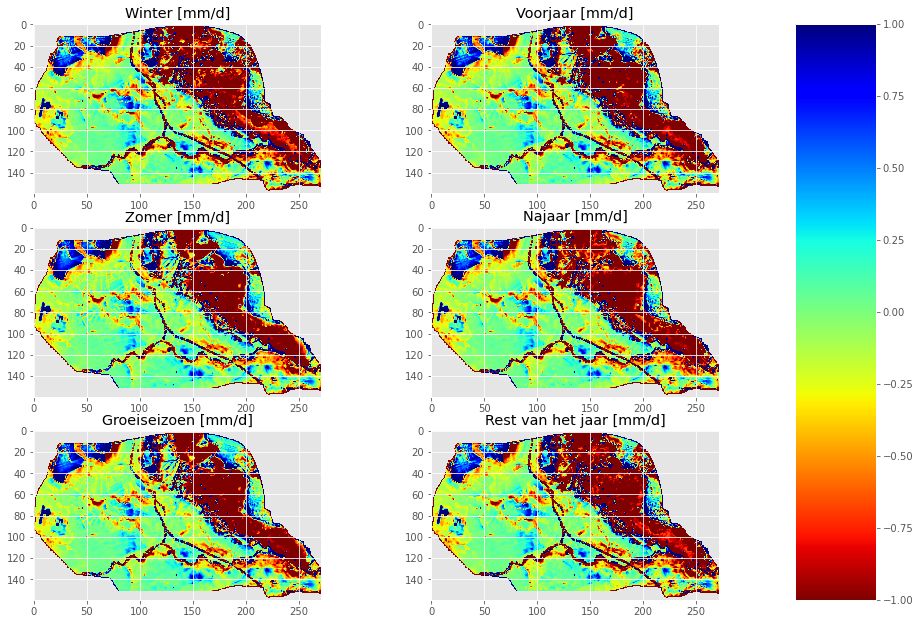

In [47]:
matplotlib.rcParams['figure.figsize'] = [15,10]
ax1 = plt.subplot(321)
plt.imshow(means[0], cmap='jet_r', vmin=-1,vmax=1)
ax1.set_title('Winter [mm/d]')
ax2 = plt.subplot(322)
plt.imshow(means[1], cmap='jet_r', vmin=-1,vmax=1)
ax2.set_title('Voorjaar [mm/d]')
ax3 = plt.subplot(323)
plt.imshow(means[2], cmap='jet_r', vmin=-1,vmax=1)
ax3.set_title('Zomer [mm/d]')
ax4 = plt.subplot(324)
plt.imshow(means[3], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Najaar [mm/d]')
ax4 = plt.subplot(325)
plt.imshow(means[4], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Groeiseizoen [mm/d]')
ax4 = plt.subplot(326)
plt.imshow(means[5], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Rest van het jaar [mm/d]')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

<a id='runoff'/>

<a id='rivierkwel'/>

## 3.4 Rivierkwel

Naast de totale gebiedsbrede flux, is ook inzicht gewenst in de invloed van hoge Lek-waterstanden. We passen daartoe de peilen op de Lek aan met onderstaande waterstanden. Zie het rapport voor meer achtergrond.

In [48]:
offsets = [0.0]+[x-3.65 for x in [3.25, 5.14, 6.30]]
offsetnames = ['REF','T1','T10','T100']
for io, o in enumerate(offsets):
    gw.prep_riverseep(offset=o, offset_name=offsetnames[io], seizoen='WINTER', export_path=os.path.join(data_path,'peilen','winter'))
    gw.prep_riverseep(offset=o, offset_name=offsetnames[io], seizoen='ZOMER', export_path=os.path.join(data_path,'peilen','zomer'))

Nu wordt voor de vier herhalingstijden een Hydromedah run van één jaar gedraaid om het verschil in beeld te brengen.

In [49]:
if False: # berekeningen duren lang, deze worden alleen uitgevoerd als dit statement "True" is.
    for i,offset in enumerate(offsetnames):

        # maak een Hydromedah object aan. Precip_path en evap_path gaan uit van de 'root' van het pad en gaat ervanuit dat 'forcing/precipiation' of 'forcing/evaporation' worden toegevoegd.
        hydromedah = Hydromedah(data_path=hydromedah_path, name='Rivierkwel_'+offset, precip_path=hydromedah_path, evap_path=hydromedah_path)
        # zet het model klaar. We hebben geen oppevlaktewater-model en Metaswap uitvoer nodig.
        hydromedah.setup_model(start_date='2010-01-01', end_date='2010-12-31', resolution=250., add_surface_water=False, afw_shape = '', metaswap_vars = [])
        # geef de zojuist geproduceerde peilen mee aan Hydromedah
        zomerpeil = os.path.join(data_path,'peilen','zomer','ZOMER_PEIL_LAAG1_1_'+offset+'.IDF')
        winterpeil = os.path.join(data_path,'peilen','winter','WINTER_PEIL_LAAG1_1_'+offset+'.IDF')
        # draai het model
        hydromedah.run_model(use_summerlevel=zomerpeil, use_winterlevel=winterpeil,silent=True )
        # en ruim overbodige uitvoer op
        hydromedah.cleanup(model_path=hydromedah_path, name='Rivierkwel_'+offset, 
                               modflow_vars = ['head','bdgflf'],
                               modflow_layers = [1],
                               metaswap_files = [])    

Haal nu voor dezelfde zes seizoenen de kwel/wegzijging data op voor het doorgerekende jaar.

In [50]:
seeplist = []
for offset in offsetnames:
    gwt = Groundwater(model_path=hydromedah_path, export_path=export_path, name='Rivierkwel_'+offset)
    temp_seep  = gwt.get_seepage()
    seeplist.append(gwt.seepage_season_means(temp_seep))

In [51]:
months = ['W','V','Z','N','GROEISEIZOEN','WINTER6']
name ='Huidig250'
for i in range(0,6):
    gw.export_raster(seeplist[1][i] - seeplist[0][i], 'SP_river_T1_'+months[i]+'_'+name+'.tif')
    gw.export_raster(seeplist[2][i] - seeplist[0][i], 'SP_river_T10_'+months[i]+'_'+name+'.tif')
    gw.export_raster(seeplist[3][i] - seeplist[0][i], 'SP_river_T100_'+months[i]+'_'+name+'.tif')

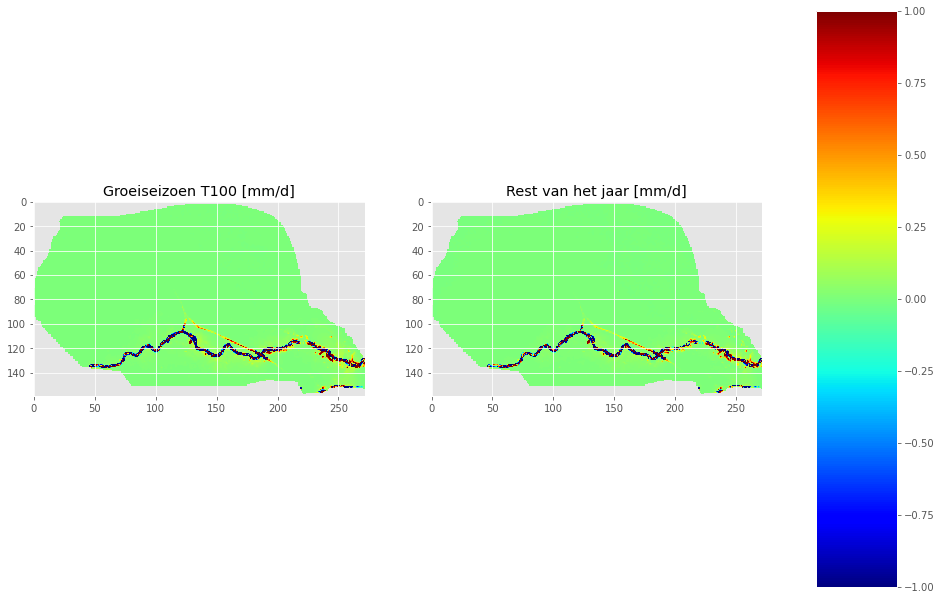

In [52]:
ax1 = plt.subplot(121)
plt.imshow(seeplist[3][4] - seeplist[0][4], cmap='jet', vmin=-1,vmax=1)
ax1.set_title('Groeiseizoen T100 [mm/d]')
ax2 = plt.subplot(122)
plt.imshow(seeplist[3][5] - seeplist[0][5], cmap='jet', vmin=-1,vmax=1)
ax2.set_title('Rest van het jaar [mm/d]')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

<a id='runoff'/>

## 3.5 Runoff karakteristieken

<a id='runoff_ahn'/>

### 3.5.1 AHN-analyses

Uit het AHN worden twee producten afgeleid (zie voor details het achtergrondrapport en het rapport van Massop e.a. (2014)):
1) maaiveldberging;
2) drempelhoogte voor surface runoff.

Het AH-binnen de code vanuit de cloud ophalen bleek geen werkbare optie, dus de AHN-tegels dienen lokaal aanwezig te zijn. Gezien de lange rekentijd om het volledige beheersgebied door te rekenen op 0.5 x 0.5 m2 resolutie, is hier een voorbeeld van één AHN-tegel opgenomen: 'ahn3_4_hdsr_selectie.tif'. Hier hoort een uitsnede bij van de de bodemeenheden voor die tegel:'bod_clusters_hdsr_uitsnede.shp'.

Het perctiel van de maaiveldcurve die voor beide gebruikt wordt is instelbaar en staat nu op 10%.

We maken eerst een 'runoff' object waarin we de paden naar de in- en uitvoer mappen goed zetten. 'name' is de naam van de Hydromedah berekening, zie boven. Als gis_path leeg is, worden meegeleverde gis-bstanden in hdsrhipy gebruikt.

In [53]:
r = Runoff(model_path=hydromedah_path, name='Huidig250', export_path=export_path)

In [54]:
r.ahn_analysis(ahndata=os.path.join(data_path, 'gis','ahn3_4_hdsr_selectie.tif'),
               bodemeenheden=os.path.join(data_path, 'gis','bod_clusters_hdsr_uitsnede.shp'), percentage=10)

Eenheid: 814
Eenheid: 815
Eenheid: 8921
Eenheid: 38921
Eenheid: 38784
Eenheid: 39471
Eenheid: 39208
Eenheid: 39238
Eenheid: 39239
Eenheid: 39510
Eenheid: 39782
Eenheid: 39827
Eenheid: 39830
Eenheid: 39833
Eenheid: 40673
Eenheid: 40674
Eenheid: 40396
Eenheid: 40455
Eenheid: 40457
Eenheid: 40462
Eenheid: 40471
Eenheid: 41101
Eenheid: 40796
Eenheid: 40800
Eenheid: 40801
Eenheid: 40731
Eenheid: 40732
Eenheid: 40733


Hier uit volgt een shapefile met daarin de waarden per bodemeenheid. We bepalen de drempelhoogte als de hoogte van het opgegeven percentiel minus de minimale hoogte en de het volume normaliseren we met het totale oppervlak van de neenheid. Dit resulteert in onderstaande (voorbeeld)-tabel en figuren voor het genormaliseerde bergingsvolume (links) en de drempelhoogte (rechts).

,OBJECTID,Shape_Area,min_hoogte,hoogte,volume,geometry,drempel,volume_norm
0,38784.0,7.243299e+04,1.864800,2.301367,1.667121e+05,"POLYGON ((142399.000 451614.000, 142282.000 45...",0.436567,2.301605
1,38921.0,1.127122e+06,-2.403666,2.243933,2.422889e+06,"POLYGON ((141638.000 450365.000, 141609.000 45...",4.647600,2.149624
2,39208.0,5.507304e+05,1.154716,2.229445,1.214028e+06,"POLYGON ((141628.000 450965.000, 141598.000 45...",1.074728,2.204396
3,39238.0,7.639901e+04,1.015227,2.261110,1.490298e+05,"POLYGON ((141282.000 448097.000, 141329.000 44...",1.245884,1.950677
4,39239.0,1.565021e+07,-2.233500,2.595600,3.984406e+07,"POLYGON ((142577.000 450338.000, 142570.000 45...",4.829100,2.545913


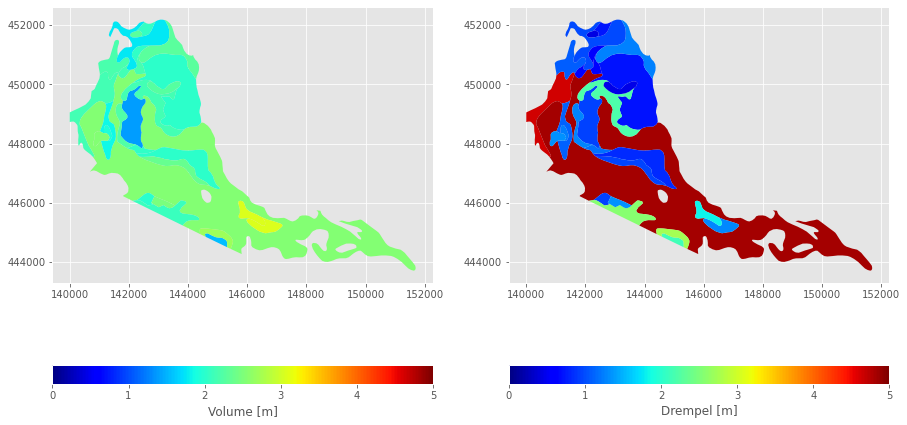

In [55]:
matplotlib.rcParams['figure.figsize'] = (15, 10)
#gdf = gpd.read_file(os.path.join(export_path, 'runoff','volledig/maaiveldcurve.shp'))
gdf = gpd.read_file(os.path.join(export_path, 'runoff','hdsr_maaiveldcurves.shp'))
gdf['drempel'] = pd.to_numeric(gdf['hoogte'])-pd.to_numeric(gdf['min_hoogte'])
gdf['volume_norm'] = pd.to_numeric(gdf['volume']) / pd.to_numeric(gdf['Shape_Area'])

fig, ax = plt.subplots(1,2)
gdf.plot('volume_norm',ax=ax[0],cmap='jet', vmin=0, vmax=5, legend=True , legend_kwds={'label': "Volume [m]",'orientation': "horizontal"})
gdf.plot('drempel',ax=ax[1],cmap='jet', legend=True, vmin=0, vmax=5, legend_kwds={'label': "Drempel [m]",'orientation': "horizontal"})
gdf.head()

Een bandbreedte bepalen we op basis van de nauwkeurigheid in het AHN. Deze is [hier](https://www.ahn.nl/kwaliteitsbeschrijving) te vinden. Voor nu nemen we de totale fout bij 1 standaardafwijking aan, dus 10 cm in totaal. De analyse wordt dan N keer herhaald waarbij random ruis over de AHN pixels, gesampled uit de opgegeven bandbreedte, wordt gelegd, resulterend in N extra shapefiles. Door de paden te wijzen naar de volledige shape met bodemeenheden en het volledige AHN wordt dit gedaan voor het gehele beheersgebied, maar dat duurt erg lang (orde 30 uur per realisatie).

In [56]:
N=2
for real in range(N):
    r.ahn_analysis(ahndata=os.path.join(data_path, 'gis','ahn3_4_hdsr_selectie.tif'),
                   bodemeenheden=os.path.join(data_path, 'gis','bod_clusters_hdsr_uitsnede.shp'), 
                   percentage=10, bandbreedte=[-0.05,0.05], realisation=real+1)

Eenheid: 814
Eenheid: 815
Eenheid: 8921
Eenheid: 38921
Eenheid: 38784
Eenheid: 39471
Eenheid: 39208
Eenheid: 39238
Eenheid: 39239
Eenheid: 39510
Eenheid: 39782
Eenheid: 39827
Eenheid: 39830
Eenheid: 39833
Eenheid: 40673
Eenheid: 40674
Eenheid: 40396
Eenheid: 40455
Eenheid: 40457
Eenheid: 40462
Eenheid: 40471
Eenheid: 41101
Eenheid: 40796
Eenheid: 40800
Eenheid: 40801
Eenheid: 40731
Eenheid: 40732
Eenheid: 40733
Eenheid: 814
Eenheid: 815
Eenheid: 8921
Eenheid: 38921
Eenheid: 38784
Eenheid: 39471
Eenheid: 39208
Eenheid: 39238
Eenheid: 39239
Eenheid: 39510
Eenheid: 39782
Eenheid: 39827
Eenheid: 39830
Eenheid: 39833
Eenheid: 40673
Eenheid: 40674
Eenheid: 40396
Eenheid: 40455
Eenheid: 40457
Eenheid: 40462
Eenheid: 40471
Eenheid: 41101
Eenheid: 40796
Eenheid: 40800
Eenheid: 40801
Eenheid: 40731
Eenheid: 40732
Eenheid: 40733


<a id='runoff_hydromedah'/>

### 3.5.2 Hydromedah-analyses

De overige twee karakteristieken worden afgeleid uit de Hydromedah resultaten: berging in de wortelzone (in Metaswap 'msw_Ssd01') en infiltratie ('msw_qinf'). Deze worden uit de berekening gehaald die in bovenstaande definitie van het runoff-object is gekozen. Voor beide parameters bepalen we (ruimtelijk) zowel het gemiddelde als de minimale per seizoen, waarbij we dezelfde seizoenen hanteren als bij de kwel- en wegzijgingsbereking. Zomer beslaat de maanden april-september en winter oktober-maart.

In [57]:
sd = r.get_msw_var('msw_Ssd01')
sd_mean = r.get_season_stat(sd, stat='mean')
sd_min = r.get_season_stat(sd, stat='min')

inf = r.get_msw_var('msw_qinf')
inf_mean = r.get_season_stat(inf, stat="mean")
inf_min = r.get_season_stat(inf, stat="min")

Analoog aan de andere producten bepalen we een bandbreedte in twee stappen. De eerste stap bevat de onnauwkeurigheid in data. Er is weinig bekend om deze op te baseren dus we zetten deze op 20 cm voor beide producten (beide hebben als eenheid meters). Vervolgens passen we op elk sample een bootstrap toe (met 3 samples) en trekken 5 samples uit de totale set. Uit alle doorgerekende mogelijkheden halen we steeds het minimum en maximum om de bandbreedte te bepalen.

In [58]:
sd_samples = sample_nauwkeurigheid(sd, [-0.1,0.1], n=3)
(sd_avmin, sd_avmax)  = MonteCarlo('metaswap_mean', sd_samples, bootstrap_n=3, n=5)
(sd_minmin, sd_minmax)  = MonteCarlo('metaswap_min', sd_samples, bootstrap_n=3, n=5)

inf_samples = sample_nauwkeurigheid(sd,[-0.1,0.1], n=3)
(inf_avmin, inf_avmax)  = MonteCarlo('metaswap_mean', inf_samples, bootstrap_n=3, n=5)
(inf_minmin, inf_minmax)  = MonteCarlo('metaswap_min', inf_samples, bootstrap_n=3, n=5)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Get min/max for season 1
Get min/max for season 2


  0%|          | 0/5 [00:00<?, ?it/s]

Get min/max for season 1
Get min/max for season 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Get min/max for season 1
Get min/max for season 2


  0%|          | 0/5 [00:00<?, ?it/s]

Get min/max for season 1
Get min/max for season 2


Tot slot nemen we de shapefile met bodemeenheden en vewijderen het open water daaruit. Vervolgens aggregeren we alle bovenstaande data naar de bodemeenheden. De kolomnamen in de shapefile (max 8 karakters) zijn opgebouwd als statistiek_bandbreedte_seizoen, waarbij statistiek gemiddelde(av) of minimum (min) kan zijn, bandbreedte lower (low) of upper (upp) en seizoen zomer (S) of winter (W). Geen bandbreedte betekent dat de modeluitvoer rechtstreeks gebruikt is zonder bewerkingen.

In [59]:
# laad de shapefile met bodemeenheden
be_shp = gpd.read_file(os.path.join(data_path,'gis','bod_clusters_hdsr.shp'))
# en verwijder open water
be_shp.drop(be_shp[be_shp['BODEMCODE']=='|g WATER'].index, axis=0, inplace=True)

outdf = be_shp.copy(deep=True)
outdf.drop([col for col in outdf.columns if col not in ['OBJECTID','BODEMCODE', 'geometry']], axis=1, inplace=True)
outdf = r.aggregate_to_shapefile(sd_mean[0], shapefile=be_shp, output_df=outdf, outcolid='av_S')  
outdf = r.aggregate_to_shapefile(sd_avmin[0], shapefile=be_shp, output_df=outdf, outcolid='av_low_S')  
outdf = r.aggregate_to_shapefile(sd_avmax[0], shapefile=be_shp, output_df=outdf, outcolid='av_upp_S')  
outdf = r.aggregate_to_shapefile(sd_min[0], shapefile=be_shp, output_df=outdf, outcolid='min_S')  
outdf = r.aggregate_to_shapefile(sd_minmin[0], shapefile=be_shp, output_df=outdf, outcolid='min_low_S')  
outdf = r.aggregate_to_shapefile(sd_minmax[0], shapefile=be_shp, output_df=outdf, outcolid='min_upp_S')  
outdf = r.aggregate_to_shapefile(sd_mean[1], shapefile=be_shp, output_df=outdf, outcolid='av_W')  
outdf = r.aggregate_to_shapefile(sd_avmin[1], shapefile=be_shp, output_df=outdf, outcolid='av_low_W')  
outdf = r.aggregate_to_shapefile(sd_avmax[1], shapefile=be_shp, output_df=outdf, outcolid='av_upp_W')  
outdf = r.aggregate_to_shapefile(sd_min[1], shapefile=be_shp, output_df=outdf, outcolid='min_W')  
outdf = r.aggregate_to_shapefile(sd_minmin[1], shapefile=be_shp, output_df=outdf, outcolid='min_low_W')  
outdf = r.aggregate_to_shapefile(sd_minmax[1], shapefile=be_shp, output_df=outdf, outcolid='min_upp_W')  
outdf.to_file(os.path.join(export_path, 'runoff', 'runoff_karakteristieken_rzstor.shp'))

outdf = be_shp.copy(deep=True)
outdf.drop([col for col in outdf.columns if col not in ['OBJECTID','BODEMCODE', 'geometry']], axis=1, inplace=True)
outdf = r.aggregate_to_shapefile(inf_mean[0], shapefile=be_shp, output_df=outdf, outcolid='av_S')  
outdf = r.aggregate_to_shapefile(inf_avmin[0], shapefile=be_shp, output_df=outdf, outcolid='av_low_S')  
outdf = r.aggregate_to_shapefile(inf_avmax[0], shapefile=be_shp, output_df=outdf, outcolid='av_upp_S')  
outdf = r.aggregate_to_shapefile(inf_min[0], shapefile=be_shp, output_df=outdf, outcolid='min_S')  
outdf = r.aggregate_to_shapefile(inf_minmin[0], shapefile=be_shp, output_df=outdf, outcolid='min_low_S')  
outdf = r.aggregate_to_shapefile(inf_minmax[0], shapefile=be_shp, output_df=outdf, outcolid='min_upp_S')  
outdf = r.aggregate_to_shapefile(inf_mean[1], shapefile=be_shp, output_df=outdf, outcolid='av_W')  
outdf = r.aggregate_to_shapefile(inf_avmin[1], shapefile=be_shp, output_df=outdf, outcolid='av_low_W')  
outdf = r.aggregate_to_shapefile(inf_avmax[1], shapefile=be_shp, output_df=outdf, outcolid='av_upp_W')  
outdf = r.aggregate_to_shapefile(inf_min[1], shapefile=be_shp, output_df=outdf, outcolid='min_W')  
outdf = r.aggregate_to_shapefile(inf_minmin[1], shapefile=be_shp, output_df=outdf, outcolid='min_low_W')  
outdf = r.aggregate_to_shapefile(inf_minmax[1], shapefile=be_shp, output_df=outdf, outcolid='min_upp_W') 
outdf.to_file(os.path.join(export_path, 'runoff', 'runoff_karakteristieken_infiltration.shp'))
